#  Import packages and data

In [201]:
import pandas as pd
import math 
import random
import numpy as np
import itertools as itt
import statsmodels.api as sm
import matplotlib.pyplot as plt
from numpy import median
from sklearn.metrics import f1_score
from scipy import stats
from scipy.stats import norm
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_hastie_10_2
import warnings

# Data Preparation

## Load 2018Q1 Loan pool d90 data 

For each loan had 3 or larger than 3 months delinquency status, I marked it as default.
<br>d_90_flag:  0---No defaut, 1--default</br>

In [202]:
df = pd.read_csv(r'C:\Users\yusha\OneDrive\Desktop\Intern\delinq_90.csv')
df.head()

,loan_identifier,origination_channel,seller_name,original_interest_rate,original_upb,original_loan_term,origination_date,first_payment_date,original_ltv,original_cltv,...,number_of_units,occupancy_type,property_state,zip_code_short,primary_mortgage_insurance_percent,product_type,coborrower_credit_score_orig,mortgage_insurance_type,relocation_mortgage,d_90_flag
0,100001040173,R,QUICKEN LOANS INC.,4.25,453000,360,01/2018,03/2018,65,65.0,...,1,P,OH,430,NaN,FRM,NaN,NaN,N,0
1,100002370993,C,"WELLS FARGO BANK, N.A.",4.25,266000,360,01/2018,03/2018,80,80.0,...,1,P,IN,467,NaN,FRM,793.0,NaN,N,0
2,100005405807,R,PMTT4,3.99,233000,360,12/2017,01/2018,79,79.0,...,1,P,CA,936,NaN,FRM,665.0,NaN,N,0
3,100008071646,R,OTHER,4.25,184000,360,01/2018,03/2018,80,80.0,...,1,P,FL,336,NaN,FRM,NaN,NaN,N,0
4,100010739040,R,OTHER,4.25,242000,360,02/2018,04/2018,49,49.0,...,1,P,CA,906,NaN,FRM,NaN,NaN,N,0


In [203]:
# show all the variables in data
df.columns

Index(['loan_identifier', 'origination_channel', 'seller_name',
       'original_interest_rate', 'original_upb', 'original_loan_term',
       'origination_date', 'first_payment_date', 'original_ltv',
       'original_cltv', 'number_of_borrowers', 'original_dti',
       'borrower_credit_score_orig', 'first_time_home_buyer', 'loan_purpose',
       'property_type', 'number_of_units', 'occupancy_type', 'property_state',
       'zip_code_short', 'primary_mortgage_insurance_percent', 'product_type',
       'coborrower_credit_score_orig', 'mortgage_insurance_type',
       'relocation_mortgage', 'd_90_flag'],
      dtype='object')

## Clean the dataset

remove non-useful variables, dealing with missing value

In [204]:
# drop non-usefull columns
df = df.drop(columns=['loan_identifier','origination_channel','seller_name',
                      'first_payment_date','origination_date','product_type','mortgage_insurance_type','relocation_mortgage',
                     'property_state','zip_code_short'])

In [205]:
# use the minimum value of borrower credit score and coborrower credit score as final credict score
df['loan_credit_score_orig'] = df.apply(lambda x: min(x['borrower_credit_score_orig'],x['coborrower_credit_score_orig']), axis=1)
df[['borrower_credit_score_orig','coborrower_credit_score_orig','loan_credit_score_orig']].head()


,borrower_credit_score_orig,coborrower_credit_score_orig,loan_credit_score_orig
0,791.0,NaN,791.0
1,736.0,793.0,736.0
2,696.0,665.0,665.0
3,767.0,NaN,767.0
4,727.0,NaN,727.0


In [206]:
# check the null value in each attribute
df.isnull().sum() 

original_interest_rate                     0
original_upb                               0
original_loan_term                         0
original_ltv                               0
original_cltv                              1
number_of_borrowers                        0
original_dti                             111
borrower_credit_score_orig               336
first_time_home_buyer                      0
loan_purpose                               0
property_type                              0
number_of_units                            0
occupancy_type                             0
primary_mortgage_insurance_percent    312107
coborrower_credit_score_orig          235424
d_90_flag                                  0
loan_credit_score_orig                   336
dtype: int64

In [207]:
# drop useless varialbes
df=df.drop(columns=['primary_mortgage_insurance_percent', 'coborrower_credit_score_orig','borrower_credit_score_orig'])
df.isnull().sum() 

original_interest_rate      0
original_upb                0
original_loan_term          0
original_ltv                0
original_cltv               1
number_of_borrowers         0
original_dti              111
first_time_home_buyer       0
loan_purpose                0
property_type               0
number_of_units             0
occupancy_type              0
d_90_flag                   0
loan_credit_score_orig    336
dtype: int64

In [208]:
df.dropna(axis=0, how='any',inplace=True)   # drop na value
df.isnull().sum() 

original_interest_rate    0
original_upb              0
original_loan_term        0
original_ltv              0
original_cltv             0
number_of_borrowers       0
original_dti              0
first_time_home_buyer     0
loan_purpose              0
property_type             0
number_of_units           0
occupancy_type            0
d_90_flag                 0
loan_credit_score_orig    0
dtype: int64

In [209]:
df = df.drop(columns = ['original_ltv'])           # drop ltv, since we use oltv 

In [210]:
# set the number of  borrowes as 2 categories : 1 , 2+
df['number_of_borrowers'] = df['number_of_borrowers'].apply(lambda x: '1' if x == 1 else '2+') 
df['number_of_borrowers'].value_counts()   

1     234672
2+    191092
Name: number_of_borrowers, dtype: int64

In [211]:
# set the number of units as 2 categories: 1 , 2+
df['number_of_units'] = df['number_of_units'].apply(lambda x: '1' if x == 1 else '2+')
df['number_of_units'].value_counts()

1     416100
2+      9664
Name: number_of_units, dtype: int64

In [212]:
# set the category variables as dummy varailbes
categorical_cols = ['number_of_borrowers',
                    'first_time_home_buyer', 'loan_purpose', 'property_type', 
                    'number_of_units','occupancy_type']

df=pd.get_dummies(df,
                   prefix_sep='_',
                   drop_first=False,
                   columns=categorical_cols)

In [213]:
df.columns

Index(['original_interest_rate', 'original_upb', 'original_loan_term',
       'original_cltv', 'original_dti', 'd_90_flag', 'loan_credit_score_orig',
       'number_of_borrowers_1', 'number_of_borrowers_2+',
       'first_time_home_buyer_N', 'first_time_home_buyer_U',
       'first_time_home_buyer_Y', 'loan_purpose_C', 'loan_purpose_P',
       'loan_purpose_R', 'property_type_CO', 'property_type_CP',
       'property_type_MH', 'property_type_PU', 'property_type_SF',
       'number_of_units_1', 'number_of_units_2+', 'occupancy_type_I',
       'occupancy_type_P', 'occupancy_type_S'],
      dtype='object')

In [214]:
df = df.drop(columns = ['first_time_home_buyer_N',
       'first_time_home_buyer_U'])

In [215]:
df.head()

,original_interest_rate,original_upb,original_loan_term,original_cltv,original_dti,d_90_flag,loan_credit_score_orig,number_of_borrowers_1,number_of_borrowers_2+,first_time_home_buyer_Y,...,property_type_CO,property_type_CP,property_type_MH,property_type_PU,property_type_SF,number_of_units_1,number_of_units_2+,occupancy_type_I,occupancy_type_P,occupancy_type_S
0,4.25,453000,360,65.0,28.0,0,791.0,1,0,0,...,0,0,0,1,0,1,0,0,1,0
1,4.25,266000,360,80.0,41.0,0,736.0,0,1,0,...,0,0,0,1,0,1,0,0,1,0
2,3.99,233000,360,79.0,48.0,0,665.0,0,1,0,...,0,0,0,0,1,1,0,0,1,0
3,4.25,184000,360,80.0,48.0,0,767.0,1,0,1,...,0,0,0,1,0,1,0,0,1,0
4,4.25,242000,360,49.0,22.0,0,727.0,1,0,0,...,0,0,0,0,1,1,0,0,1,0


## Prepare a copy for the cleaned dataset:
Since we need a another dataset with transforming all variables to dummy variable.

In [262]:
df_dummy=df.copy()

In [263]:
df_dummy.shape

(425764, 23)

In [264]:
# change numerical varaible to categorical groups
df_dummy['loan_credit_score_orig']=pd.cut(df['loan_credit_score_orig'],bins=[0,620,660,700,740,780,850],right=True,duplicates='drop')
df_dummy['original_upb']=pd.cut(df['original_upb'],bins=[0,85000,110000,125000,150000,175000,200000,417000,1500000],right=True,duplicates='drop')
df_dummy['original_interest_rate']=pd.cut(df['original_interest_rate'],bins=[0,3,4,5,6,8],right=True,duplicates='drop')
df_dummy['original_cltv']=pd.cut(df['original_cltv'],bins=[0,60,70,80,90,120],right=True,duplicates='drop')
df_dummy['original_dti']=pd.cut(df['original_dti'],bins=[0,20,30,40,45,100],right=True,duplicates='drop')
df_dummy['original_loan_term']=pd.cut(df['original_loan_term'],bins=[0,120,180,240,300,360],right=True,duplicates='drop')
df_dummy.head()

,original_interest_rate,original_upb,original_loan_term,original_cltv,original_dti,d_90_flag,loan_credit_score_orig,number_of_borrowers_1,number_of_borrowers_2+,first_time_home_buyer_Y,...,property_type_CO,property_type_CP,property_type_MH,property_type_PU,property_type_SF,number_of_units_1,number_of_units_2+,occupancy_type_I,occupancy_type_P,occupancy_type_S
0,"(4, 5]","(417000, 1500000]","(300, 360]","(60, 70]","(20, 30]",0,"(780, 850]",1,0,0,...,0,0,0,1,0,1,0,0,1,0
1,"(4, 5]","(200000, 417000]","(300, 360]","(70, 80]","(40, 45]",0,"(700, 740]",0,1,0,...,0,0,0,1,0,1,0,0,1,0
2,"(3, 4]","(200000, 417000]","(300, 360]","(70, 80]","(45, 100]",0,"(660, 700]",0,1,0,...,0,0,0,0,1,1,0,0,1,0
3,"(4, 5]","(175000, 200000]","(300, 360]","(70, 80]","(45, 100]",0,"(740, 780]",1,0,1,...,0,0,0,1,0,1,0,0,1,0
4,"(4, 5]","(200000, 417000]","(300, 360]","(0, 60]","(20, 30]",0,"(700, 740]",1,0,0,...,0,0,0,0,1,1,0,0,1,0


In [265]:
# change the variables to dummy varialbes
continius_variables = ['original_interest_rate', 'original_upb', 'original_cltv', 
             'original_dti', 'loan_credit_score_orig','original_loan_term']
df_dummy_new=pd.get_dummies(df_dummy,prefix_sep='_',drop_first=False,columns=continius_variables)

In [266]:
df_dummy_new.head()

,d_90_flag,number_of_borrowers_1,number_of_borrowers_2+,first_time_home_buyer_Y,loan_purpose_C,loan_purpose_P,loan_purpose_R,property_type_CO,property_type_CP,property_type_MH,...,"loan_credit_score_orig_(620, 660]","loan_credit_score_orig_(660, 700]","loan_credit_score_orig_(700, 740]","loan_credit_score_orig_(740, 780]","loan_credit_score_orig_(780, 850]","original_loan_term_(0, 120]","original_loan_term_(120, 180]","original_loan_term_(180, 240]","original_loan_term_(240, 300]","original_loan_term_(300, 360]"
0,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,0,0,1,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,0,0,1,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,0,1,0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,0,1,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [267]:
df_dummy_new.shape

(425764, 51)

In [268]:
df_dummy_new.columns

Index(['d_90_flag', 'number_of_borrowers_1', 'number_of_borrowers_2+',
       'first_time_home_buyer_Y', 'loan_purpose_C', 'loan_purpose_P',
       'loan_purpose_R', 'property_type_CO', 'property_type_CP',
       'property_type_MH', 'property_type_PU', 'property_type_SF',
       'number_of_units_1', 'number_of_units_2+', 'occupancy_type_I',
       'occupancy_type_P', 'occupancy_type_S', 'original_interest_rate_(0, 3]',
       'original_interest_rate_(3, 4]', 'original_interest_rate_(4, 5]',
       'original_interest_rate_(5, 6]', 'original_interest_rate_(6, 8]',
       'original_upb_(0, 85000]', 'original_upb_(85000, 110000]',
       'original_upb_(110000, 125000]', 'original_upb_(125000, 150000]',
       'original_upb_(150000, 175000]', 'original_upb_(175000, 200000]',
       'original_upb_(200000, 417000]', 'original_upb_(417000, 1500000]',
       'original_cltv_(0, 60]', 'original_cltv_(60, 70]',
       'original_cltv_(70, 80]', 'original_cltv_(80, 90]',
       'original_cltv_(90, 1

## Divide the dataset into training/testing dataset

In [223]:
# divide the dataset into training data and testing data
from sklearn.model_selection import train_test_split, GridSearchCV
df.reset_index(inplace=True, drop = True)
y = df['d_90_flag']
X = df.drop(columns = ['d_90_flag'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state= 42)
model_list = {} #to store the models

In [269]:
# divide the dummy dataset into training data and testing data
df_dummy_new.reset_index(inplace=True, drop = True)
y_dummy = df_dummy_new['d_90_flag']
X_dummy = df_dummy_new.drop(columns = ['d_90_flag'])
X_train_dummy, X_test_dummy, y_train_dummy, y_test_dummy = train_test_split(X_dummy, y_dummy, test_size=0.3, random_state= 42)


# Model Building

## logistic Regression model

In [225]:
%%time
from sklearn.linear_model import LogisticRegression
param_grid = {'C': [0.01,0.05,0.1,1]}
grid = GridSearchCV(LogisticRegression(solver = 'liblinear'), param_grid, cv = 5, scoring = "roc_auc")
grid.fit(X_train, y_train)
print(grid.best_params_)
logit_model = LogisticRegression(**grid.best_params_)
logit_model.fit(X_train, y_train)
model_list['logit_model'] = logit_model

{'C': 0.1}


C:\Users\yusha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Wall time: 41.2 s


## Logistic model with spline

In [226]:
df_sp = df.copy()

In [227]:
# Create Splines
df_sp['original_interest_rate_4.1'] = df_sp['original_interest_rate'].apply(lambda x: max(x-4.1,0))
df_sp['original_interest_rate_5.0'] = df_sp['original_interest_rate'].apply(lambda x: max(x-5.0,0))

df_sp['original_cltv_85'] = df_sp['original_cltv'].apply(lambda x: max(x-85,0))
df_sp['original_cltv_95'] = df_sp['original_cltv'].apply(lambda x: max(x-95,0))

df_sp['loan_credit_score_orig_695'] = df_sp['loan_credit_score_orig'].apply(lambda x: max(x-695,0))
df_sp['loan_credit_score_orig_720'] = df_sp['loan_credit_score_orig'].apply(lambda x: max(x-720,0))
df_sp.head()

,original_interest_rate,original_upb,original_loan_term,original_cltv,original_dti,d_90_flag,loan_credit_score_orig,number_of_borrowers_1,number_of_borrowers_2+,first_time_home_buyer_Y,...,number_of_units_2+,occupancy_type_I,occupancy_type_P,occupancy_type_S,original_interest_rate_4.1,original_interest_rate_5.0,original_cltv_85,original_cltv_95,loan_credit_score_orig_695,loan_credit_score_orig_720
0,4.25,453000,360,65.0,28.0,0,791.0,1,0,0,...,0,0,1,0,0.15,0.0,0.0,0.0,96.0,71.0
1,4.25,266000,360,80.0,41.0,0,736.0,0,1,0,...,0,0,1,0,0.15,0.0,0.0,0.0,41.0,16.0
2,3.99,233000,360,79.0,48.0,0,665.0,0,1,0,...,0,0,1,0,0.00,0.0,0.0,0.0,0.0,0.0
3,4.25,184000,360,80.0,48.0,0,767.0,1,0,1,...,0,0,1,0,0.15,0.0,0.0,0.0,72.0,47.0
4,4.25,242000,360,49.0,22.0,0,727.0,1,0,0,...,0,0,1,0,0.15,0.0,0.0,0.0,32.0,7.0


In [228]:
y_sp = df_sp['d_90_flag']
X_sp = df_sp.drop(columns = ['d_90_flag'])
X_train_sp, X_test_sp, y_train_sp, y_test_sp = train_test_split(X_sp, y_sp, test_size=0.3, random_state= 42)

In [229]:
%%time
param_grid = {'C': [0.01,0.05,0.1,1]}
grid = GridSearchCV(LogisticRegression(solver = 'liblinear'), param_grid, cv = 5, scoring = "roc_auc")
grid.fit(X_train_sp, y_train_sp)
print(grid.best_params_)
logit_model_sp = LogisticRegression(**grid.best_params_)
logit_model_sp.fit(X_train_sp, y_train_sp)
model_list['logit_model_sp'] = logit_model_sp

{'C': 0.05}


C:\Users\yusha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Wall time: 47.3 s


## Xgboost

In [230]:
from xgboost import XGBClassifier

In [231]:
%%time
param_grid = {"learning_rate": [0.01, 0.1,0.5], "n_estimators": [100,300,500], 'max_depth':[3,4,5]}
grid = GridSearchCV(XGBClassifier(), param_grid, cv = 5, scoring = "roc_auc")
grid.fit(X_train, y_train)
print("best hyperparameters through grid search: ", grid.best_params_)
xgb_model = XGBClassifier(**grid.best_params_)
xgb_model.fit(X_train, y_train)
model_list['xgb_model'] = xgb_model

best hyperparameters through grid search:  {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
Wall time: 1h 1min 2s


## Random Forest

In [232]:
%%time
from sklearn.ensemble import RandomForestClassifier
param_grid = {'max_depth': [2,4,6,8], "n_estimators": [100,200,300,500]}
grid = GridSearchCV(RandomForestClassifier(), param_grid, cv = 5, scoring = "roc_auc")
grid.fit(X_train, y_train)
print(grid.best_params_)
rf_model = RandomForestClassifier(**grid.best_params_)
rf_model.fit(X_train, y_train)
model_list['rf_model'] = rf_model

{'max_depth': 8, 'n_estimators': 500}
Wall time: 49min 17s


## Logistic Regression Model------transform all variables as dummy

##### Logistic Regression model with all dummy variable

In [254]:
%%time
param_grid_dummy = {'C': [0.01,0.05,0.1,1]}
grid_dummy= GridSearchCV(LogisticRegression(solver = 'liblinear'), param_grid_dummy , cv = 5, scoring = "roc_auc")
grid_dummy.fit(X_train_dummy, y_train_dummy)
print(grid_dummy.best_params_)
logit_model_dummy= LogisticRegression(**grid_dummy.best_params_)
logit_model_dummy.fit(X_train_dummy, y_train_dummy)
model_list['logit_model_dummy'] = logit_model_dummy

{'C': 0.1}


C:\Users\yusha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Wall time: 33.1 s


#  In Sample Model validation

## logistic model

In [233]:
logit_model.coef_

array([[ 3.00975254e-04, -9.80730400e-07,  1.12650689e-02,
         6.60196505e-03,  3.56050989e-03, -1.28107951e-02,
         2.00197866e-04, -1.78615701e-04,  9.59839343e-05,
         1.84625913e-05,  4.85181261e-05, -4.53985530e-05,
        -1.94527350e-05, -1.73406203e-06,  1.74752069e-06,
        -1.03480851e-05,  5.13695258e-05,  2.72426926e-05,
        -5.66052823e-06, -2.87201787e-05,  6.86593641e-05,
        -1.83570209e-05]])

In [235]:
# calculate the probability use logsitc formula
def prob(a):
    prob = 1 / (1 + math.exp(-a))
    return prob

predict = X * logit_model.coef_

predict['self_cal'] = predict.apply(sum, axis = 1)
predict['self_cal'] = predict['self_cal']+float(logit_model.intercept_)
predict['self_cal'] = predict['self_cal'].apply(prob)

predict['prob'] = pd.DataFrame(logit_model.predict_proba(X))[1]

predict['d90_flag'] = y 

In [236]:
predict.head()

,original_interest_rate,original_upb,original_loan_term,original_cltv,original_dti,loan_credit_score_orig,number_of_borrowers_1,number_of_borrowers_2+,first_time_home_buyer_Y,loan_purpose_C,...,property_type_PU,property_type_SF,number_of_units_1,number_of_units_2+,occupancy_type_I,occupancy_type_P,occupancy_type_S,self_cal,prob,d90_flag
0,0.001279,-0.444271,4.055425,0.429128,0.099694,-10.133339,0.0002,-0.000000,0.000000,0.000018,...,-0.00001,0.000000,0.000027,-0.0,-0.0,0.000069,-0.0,0.002493,0.002493,0
1,0.001279,-0.260874,4.055425,0.528157,0.145981,-9.428745,0.0000,-0.000179,0.000000,0.000000,...,-0.00001,0.000000,0.000027,-0.0,-0.0,0.000069,-0.0,0.006972,0.006972,0
2,0.001201,-0.228510,4.055425,0.521555,0.170904,-8.519179,0.0000,-0.000179,0.000000,0.000000,...,-0.00000,0.000051,0.000027,-0.0,-0.0,0.000069,-0.0,0.018010,0.018010,0
3,0.001279,-0.180454,4.055425,0.528157,0.170904,-9.825880,0.0002,-0.000000,0.000096,0.000000,...,-0.00001,0.000000,0.000027,-0.0,-0.0,0.000069,-0.0,0.005220,0.005220,0
4,0.001279,-0.237337,4.055425,0.323496,0.078331,-9.313448,0.0002,-0.000000,0.000000,0.000000,...,-0.00000,0.000051,0.000027,-0.0,-0.0,0.000069,-0.0,0.006109,0.006109,0


In [237]:
val_log = pd.concat([X,predict.iloc[:,-3:]],axis = 1)

In [238]:
val_log.head()

,original_interest_rate,original_upb,original_loan_term,original_cltv,original_dti,loan_credit_score_orig,number_of_borrowers_1,number_of_borrowers_2+,first_time_home_buyer_Y,loan_purpose_C,...,property_type_PU,property_type_SF,number_of_units_1,number_of_units_2+,occupancy_type_I,occupancy_type_P,occupancy_type_S,self_cal,prob,d90_flag
0,4.25,453000,360,65.0,28.0,791.0,1,0,0,1,...,1,0,1,0,0,1,0,0.002493,0.002493,0
1,4.25,266000,360,80.0,41.0,736.0,0,1,0,0,...,1,0,1,0,0,1,0,0.006972,0.006972,0
2,3.99,233000,360,79.0,48.0,665.0,0,1,0,0,...,0,1,1,0,0,1,0,0.018010,0.018010,0
3,4.25,184000,360,80.0,48.0,767.0,1,0,1,0,...,1,0,1,0,0,1,0,0.005220,0.005220,0
4,4.25,242000,360,49.0,22.0,727.0,1,0,0,0,...,0,1,1,0,0,1,0,0.006109,0.006109,0


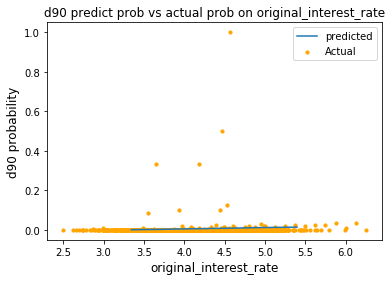

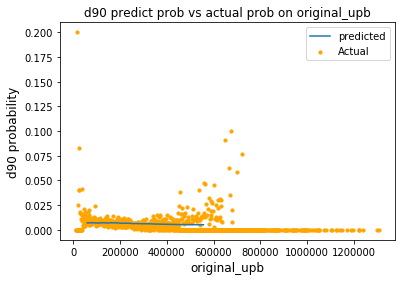

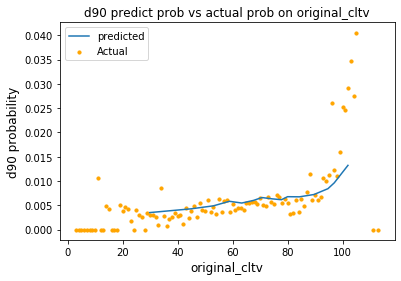

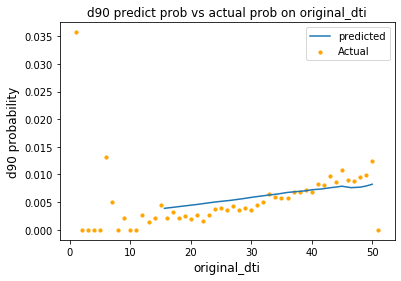

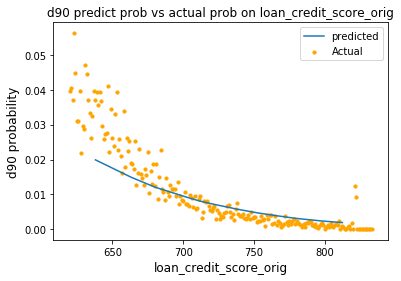

In [239]:
# compare predicted probability vs actual probability in each variable group 
continius = ['original_interest_rate', 'original_upb', 'original_cltv', 
             'original_dti', 'loan_credit_score_orig']
for col in continius:
    plt.subplot(111)
    a = val_log.groupby(pd.qcut(val_log[col],20,duplicates = 'drop'))[[col, 'prob']].mean()
    plt.plot(a[col],a['prob'],label='predicted')

    b = val_log.groupby([col],as_index=False)[[col, 'd90_flag']].mean()
    plt.scatter(b[col],b['d90_flag'],color='orange', s=10,label='Actual')

    plt.title("d90 predict prob vs actual prob on " + col)
    plt.xlabel(col, fontsize =12)
    plt.ylabel('d90 probability',fontsize =12)
    plt.legend()
    plt.show()

## logistic regression with spine

In [240]:
def prob(a):
    prob = 1 / (1 + math.exp(-a))
    return prob

predict = X_sp * logit_model_sp.coef_



predict['self_cal'] = predict.apply(sum, axis = 1)
predict['self_cal'] = predict['self_cal']+float(logit_model_sp.intercept_)
predict['self_cal'] = predict['self_cal'].apply(prob)

predict['prob'] = pd.DataFrame(logit_model_sp.predict_proba(X_sp))[1]

predict['d90_flag'] = y_sp

In [241]:
val_logsp = pd.concat([X_sp,predict.iloc[:,-3:]],axis = 1)
val_logsp.head()

,original_interest_rate,original_upb,original_loan_term,original_cltv,original_dti,loan_credit_score_orig,number_of_borrowers_1,number_of_borrowers_2+,first_time_home_buyer_Y,loan_purpose_C,...,occupancy_type_S,original_interest_rate_4.1,original_interest_rate_5.0,original_cltv_85,original_cltv_95,loan_credit_score_orig_695,loan_credit_score_orig_720,self_cal,prob,d90_flag
0,4.25,453000,360,65.0,28.0,791.0,1,0,0,1,...,0,0.15,0.0,0.0,0.0,96.0,71.0,0.000983,0.000983,0
1,4.25,266000,360,80.0,41.0,736.0,0,1,0,0,...,0,0.15,0.0,0.0,0.0,41.0,16.0,0.006064,0.006064,0
2,3.99,233000,360,79.0,48.0,665.0,0,1,0,0,...,0,0.00,0.0,0.0,0.0,0.0,0.0,0.021648,0.021648,0
3,4.25,184000,360,80.0,48.0,767.0,1,0,1,0,...,0,0.15,0.0,0.0,0.0,72.0,47.0,0.003081,0.003081,0
4,4.25,242000,360,49.0,22.0,727.0,1,0,0,0,...,0,0.15,0.0,0.0,0.0,32.0,7.0,0.005686,0.005686,0


## Rondom Forest

In [242]:
val_rf = pd.concat([X,pd.DataFrame(rf_model.predict_proba(X))[[1]]],axis = 1)
val_rf.rename(columns = {1:'prob'}, inplace = True)
val_rf.head()

,original_interest_rate,original_upb,original_loan_term,original_cltv,original_dti,loan_credit_score_orig,number_of_borrowers_1,number_of_borrowers_2+,first_time_home_buyer_Y,loan_purpose_C,...,property_type_CP,property_type_MH,property_type_PU,property_type_SF,number_of_units_1,number_of_units_2+,occupancy_type_I,occupancy_type_P,occupancy_type_S,prob
0,4.25,453000,360,65.0,28.0,791.0,1,0,0,1,...,0,0,1,0,1,0,0,1,0,0.003523
1,4.25,266000,360,80.0,41.0,736.0,0,1,0,0,...,0,0,1,0,1,0,0,1,0,0.001722
2,3.99,233000,360,79.0,48.0,665.0,0,1,0,0,...,0,0,0,1,1,0,0,1,0,0.006806
3,4.25,184000,360,80.0,48.0,767.0,1,0,1,0,...,0,0,1,0,1,0,0,1,0,0.005954
4,4.25,242000,360,49.0,22.0,727.0,1,0,0,0,...,0,0,0,1,1,0,0,1,0,0.004268


## XGboost

In [243]:
val_xgb = pd.concat([X,pd.DataFrame(xgb_model.predict_proba(X))[[1]]],axis = 1)
val_xgb.rename(columns = {1:'prob'}, inplace = True)
val_xgb.head()

,original_interest_rate,original_upb,original_loan_term,original_cltv,original_dti,loan_credit_score_orig,number_of_borrowers_1,number_of_borrowers_2+,first_time_home_buyer_Y,loan_purpose_C,...,property_type_CP,property_type_MH,property_type_PU,property_type_SF,number_of_units_1,number_of_units_2+,occupancy_type_I,occupancy_type_P,occupancy_type_S,prob
0,4.25,453000,360,65.0,28.0,791.0,1,0,0,1,...,0,0,1,0,1,0,0,1,0,0.001638
1,4.25,266000,360,80.0,41.0,736.0,0,1,0,0,...,0,0,1,0,1,0,0,1,0,0.001514
2,3.99,233000,360,79.0,48.0,665.0,0,1,0,0,...,0,0,0,1,1,0,0,1,0,0.010140
3,4.25,184000,360,80.0,48.0,767.0,1,0,1,0,...,0,0,1,0,1,0,0,1,0,0.005191
4,4.25,242000,360,49.0,22.0,727.0,1,0,0,0,...,0,0,0,1,1,0,0,1,0,0.004742


## Logistic model with all dummy variable

In [270]:
logit_model_dummy.coef_

array([[-2.26899074e-01, -1.09481983e+00,  1.08704556e-01,
        -2.72955757e-01, -4.98991163e-01, -5.49771987e-01,
        -5.40319618e-01, -1.82470098e-01, -1.31076931e-01,
        -2.78557169e-01, -1.89295091e-01, -6.55738765e-01,
        -6.65980142e-01, -5.43176559e-01, -2.91968603e-01,
        -4.86573745e-01, -2.87653696e-01, -7.99892057e-01,
        -3.03606920e-01, -3.16634952e-02,  1.01097262e-01,
        -7.27008841e-02, -9.75980313e-02, -1.43854799e-01,
        -2.07613881e-01, -1.51624109e-01, -2.64334127e-01,
        -2.45786178e-01, -1.38206897e-01, -6.75051666e-01,
        -5.60567621e-01, -4.11590349e-01,  3.03393992e-02,
         2.95151330e-01, -5.52142540e-01, -5.40048663e-01,
        -2.71316207e-01, -3.71209452e-02,  7.89094486e-02,
         6.90566426e-01,  1.10696878e+00,  2.17295388e-01,
        -5.43471709e-01, -1.16054809e+00, -1.63252970e+00,
        -4.11885714e-01, -3.38466634e-01, -4.83815751e-01,
         1.39645199e-05, -8.75647723e-02]])

In [271]:
def prob(p):
    prob = 1 / (1 + math.exp(-p))
    return prob

predict_dummy = X_dummy * logit_model_dummy.coef_

predict_dummy['self_cal'] = predict_dummy.apply(sum, axis = 1)
predict_dummy['self_cal'] = predict_dummy['self_cal']+float(logit_model_dummy.intercept_)
predict_dummy['self_cal'] = predict_dummy['self_cal'].apply(prob)

predict_dummy['prob'] = pd.DataFrame(logit_model_dummy.predict_proba(X_dummy))[1]

predict_dummy['d90_flag'] = y_dummy 

In [272]:
predict_dummy.head()

,number_of_borrowers_1,number_of_borrowers_2+,first_time_home_buyer_Y,loan_purpose_C,loan_purpose_P,loan_purpose_R,property_type_CO,property_type_CP,property_type_MH,property_type_PU,...,"loan_credit_score_orig_(740, 780]","loan_credit_score_orig_(780, 850]","original_loan_term_(0, 120]","original_loan_term_(120, 180]","original_loan_term_(180, 240]","original_loan_term_(240, 300]","original_loan_term_(300, 360]",self_cal,prob,d90_flag
0,-0.226899,-0.00000,0.000000,-0.272956,-0.000000,-0.000000,-0.0,-0.0,-0.0,-0.278557,...,-0.000000,-1.63253,-0.0,-0.0,-0.0,0.0,-0.087565,0.001814,0.001814,0
1,-0.000000,-1.09482,0.000000,-0.000000,-0.000000,-0.549772,-0.0,-0.0,-0.0,-0.278557,...,-0.000000,-0.00000,-0.0,-0.0,-0.0,0.0,-0.087565,0.002954,0.002954,0
2,-0.000000,-1.09482,0.000000,-0.000000,-0.000000,-0.549772,-0.0,-0.0,-0.0,-0.000000,...,-0.000000,-0.00000,-0.0,-0.0,-0.0,0.0,-0.087565,0.004717,0.004717,0
3,-0.226899,-0.00000,0.108705,-0.000000,-0.498991,-0.000000,-0.0,-0.0,-0.0,-0.278557,...,-1.160548,-0.00000,-0.0,-0.0,-0.0,0.0,-0.087565,0.004899,0.004899,0
4,-0.226899,-0.00000,0.000000,-0.000000,-0.000000,-0.549772,-0.0,-0.0,-0.0,-0.000000,...,-0.000000,-0.00000,-0.0,-0.0,-0.0,0.0,-0.087565,0.003572,0.003572,0


In [273]:
val_log_dummy = pd.concat([X_dummy ,predict_dummy.iloc[:,-3:]],axis = 1)

In [274]:
val_log_dummy.head()

,number_of_borrowers_1,number_of_borrowers_2+,first_time_home_buyer_Y,loan_purpose_C,loan_purpose_P,loan_purpose_R,property_type_CO,property_type_CP,property_type_MH,property_type_PU,...,"loan_credit_score_orig_(740, 780]","loan_credit_score_orig_(780, 850]","original_loan_term_(0, 120]","original_loan_term_(120, 180]","original_loan_term_(180, 240]","original_loan_term_(240, 300]","original_loan_term_(300, 360]",self_cal,prob,d90_flag
0,1,0,0,1,0,0,0,0,0,1,...,0,1,0,0,0,0,1,0.001814,0.001814,0
1,0,1,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,1,0.002954,0.002954,0
2,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0.004717,0.004717,0
3,1,0,1,0,1,0,0,0,0,1,...,1,0,0,0,0,0,1,0.004899,0.004899,0
4,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0.003572,0.003572,0


## Check models' predict probability vs actual probability in each variable groups

##### put all the model validation result together

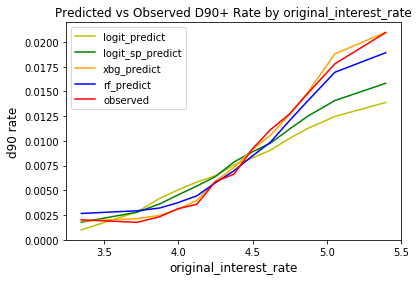

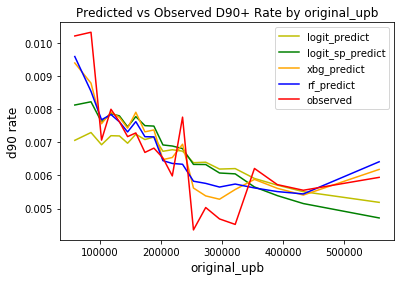

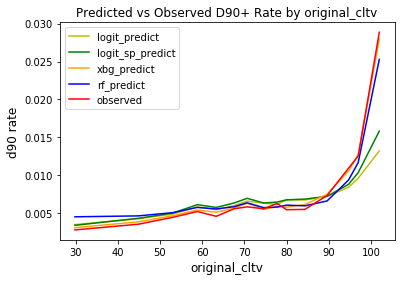

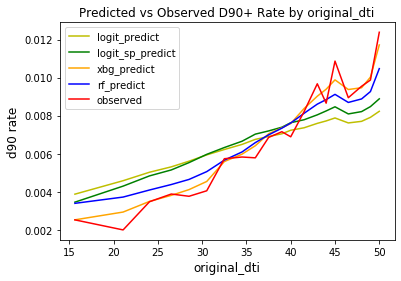

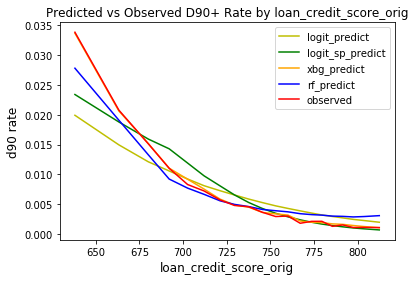

In [259]:
# put all models together
continius = ['original_interest_rate', 'original_upb', 'original_cltv', 
             'original_dti', 'loan_credit_score_orig']
for col in continius:
    plt.subplot(111)
    a = val_log.groupby(pd.qcut(val_log[col],20,duplicates = 'drop'))[[col, 'prob']].mean()
    plt.plot(a[col],a['prob'], c= 'y', label='logit_predict')
    
    c = val_logsp.groupby(pd.qcut(val_logsp[col],20,duplicates = 'drop'))[[col, 'prob']].mean()
    plt.plot(c[col],c['prob'], c= 'g', label='logit_sp_predict')
    
    d = val_xgb.groupby(pd.qcut(val_xgb[col],20,duplicates = 'drop'))[[col, 'prob']].mean()
    plt.plot(d[col],d['prob'], c= 'orange', label='xbg_predict')
    
    e = val_rf.groupby(pd.qcut(val_rf[col],20,duplicates = 'drop'))[[col, 'prob']].mean()
    plt.plot(e[col],e['prob'], c= 'b', label='rf_predict')
    

    b = df.groupby(pd.qcut(df[col],20,duplicates = 'drop'))[[col, 'd_90_flag']].mean()
    plt.plot(b[col],b['d_90_flag'], c= 'r', label = 'observed')
    
    #plt.savefig("figs/bivariate_analysis/count_vs_" + col + ".png")
    plt.title("Predicted vs Observed D90+ Rate by " + col)
    plt.legend()
    plt.xlabel(col, fontsize =12)
    plt.ylabel('d90 rate',fontsize =12)
    plt.show()


In [275]:
d_dummy=pd.concat([df_dummy,predict_dummy.iloc[:,-3:]],axis = 1)
d_dummy.head()

,original_interest_rate,original_upb,original_loan_term,original_cltv,original_dti,d_90_flag,loan_credit_score_orig,number_of_borrowers_1,number_of_borrowers_2+,first_time_home_buyer_Y,...,property_type_PU,property_type_SF,number_of_units_1,number_of_units_2+,occupancy_type_I,occupancy_type_P,occupancy_type_S,self_cal,prob,d90_flag
0,"(4, 5]","(417000, 1500000]","(300, 360]","(60, 70]","(20, 30]",0,"(780, 850]",1,0,0,...,1,0,1,0,0,1,0,0.001814,0.001814,0
1,"(4, 5]","(200000, 417000]","(300, 360]","(70, 80]","(40, 45]",0,"(700, 740]",0,1,0,...,1,0,1,0,0,1,0,0.002954,0.002954,0
2,"(3, 4]","(200000, 417000]","(300, 360]","(70, 80]","(45, 100]",0,"(660, 700]",0,1,0,...,0,1,1,0,0,1,0,0.004717,0.004717,0
3,"(4, 5]","(175000, 200000]","(300, 360]","(70, 80]","(45, 100]",0,"(740, 780]",1,0,1,...,1,0,1,0,0,1,0,0.004899,0.004899,0
4,"(4, 5]","(200000, 417000]","(300, 360]","(0, 60]","(20, 30]",0,"(700, 740]",1,0,0,...,0,1,1,0,0,1,0,0.003572,0.003572,0


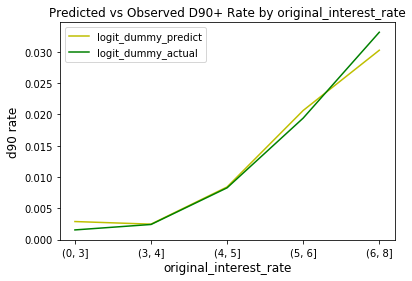

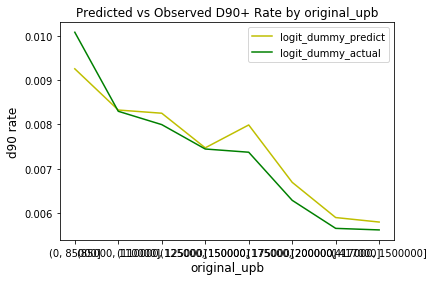

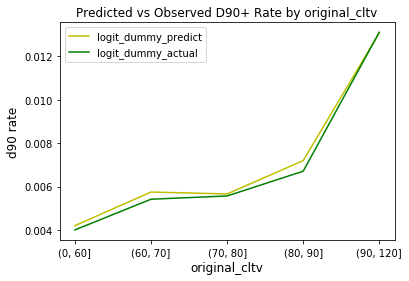

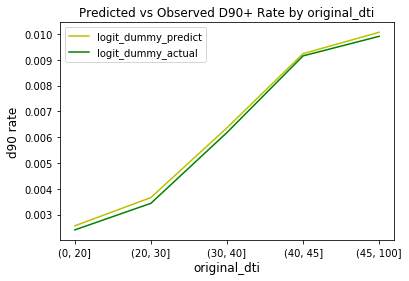

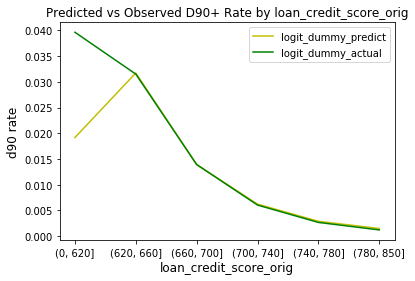

In [277]:
continius = ['original_interest_rate', 'original_upb', 'original_cltv', 
            'original_dti', 'loan_credit_score_orig']

for col in continius:
    plt.subplot(111)
    a = d_dummy.groupby(col)[[col, 'prob']].mean().reset_index()
    x=a[col].astype(str)
    plt.plot(x,a['prob'],c= 'y', label='logit_dummy_predict')
    
    c = d_dummy.groupby(col)[[col, 'd90_flag']].mean().reset_index()
    x1=a[col].astype(str)
    plt.plot(x1,c['d90_flag'], c= 'g', label='logit_dummy_actual')
    
    plt.title("Predicted vs Observed D90+ Rate by " + col)
    plt.legend()
    plt.xlabel(col, fontsize =12)
    plt.ylabel('d90 rate',fontsize =12)
    plt.show()


When validate models, I used in sample validation firstly, I cut the features into different groups, and compare the prediction  value with the actual value in different groups, from above plots, we can see XGboos follows the actual probability best.

# Model Calibration:  five percentile comparation between predicted probability vs acutal 

## logistic regression model 

In [152]:
a = val_log.groupby(pd.qcut(val_log['prob'],20,duplicates = 'drop'))['prob'].mean()
b = val_log.groupby(pd.qcut(val_log['prob'],20,duplicates = 'drop'))['d90_flag'].mean()
data=pd.DataFrame({'predicted':a,'Actual':b})
data=data.reset_index()
data

,prob,predicted,Actual
0,"(-0.0009116, 0.000478]",0.000349,0.000423
1,"(0.000478, 0.000841]",0.000648,0.001174
2,"(0.000841, 0.0015]",0.001131,0.002396
3,"(0.0015, 0.00235]",0.001977,0.003523
4,"(0.00235, 0.00277]",0.002576,0.001879
5,"(0.00277, 0.00311]",0.002942,0.001738
6,"(0.00311, 0.00344]",0.003272,0.002161
7,"(0.00344, 0.00381]",0.003621,0.002161
8,"(0.00381, 0.00423]",0.004013,0.002349
9,"(0.00423, 0.00472]",0.004468,0.003100


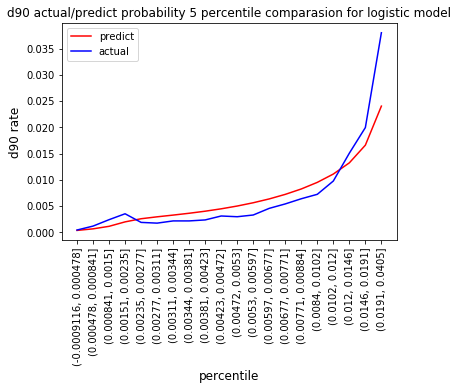

In [143]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.plot(data['predicted'],c= 'r', label='predict')
ax.plot(data['Actual'], c= 'b', label = 'actual')
ticks=ax.set_xticks(np.arange(0,20))
labels=ax.set_xticklabels(['(-0.0009116, 0.000478]','(0.000478, 0.000841]','(0.000841, 0.0015]','(0.00151, 0.00235]',
                           '(0.00235, 0.00277]','(0.00277, 0.00311]','(0.00311, 0.00344]','(0.00344, 0.00381]',
                           '(0.00381, 0.00423]','(0.00423, 0.00472]','(0.00472, 0.0053]','(0.0053, 0.00597]',
                           '(0.00597, 0.00677]','(0.00677, 0.00771]','(0.00771, 0.00884]','(0.0084, 0.0102]',
                           '(0.0102, 0.012]','(0.012, 0.0146]','(0.0146, 0.0191]','(0.0191, 0.0405]'],rotation=90)
plt.title("d90 actual/predict probability 5 percentile comparasion for logistic model")
plt.legend()
plt.xlabel('percentile', fontsize =12)
plt.ylabel('d90 rate',fontsize =12)
#plt.savefig('percentile_compare_on2018Q1_logistc.png')
plt.show()


##  random forest

In [144]:
val_rf['d90_flag'] = y 
c = val_rf.groupby(pd.qcut(val_rf['prob'],20,duplicates = 'drop'))['prob'].mean()
d = val_rf.groupby(pd.qcut(val_rf['prob'],20,duplicates = 'drop'))['d90_flag'].mean()
data2=pd.DataFrame({'predicted':c,'Actual':d})
data2=data2.reset_index()
data2

,prob,predicted,Actual
0,"(-0.0007520000000000001, 0.00083]",0.000669,0.000047
1,"(0.00083, 0.00107]",0.000956,0.000047
2,"(0.00107, 0.00133]",0.001198,0.000235
3,"(0.00133, 0.00165]",0.001489,0.000423
4,"(0.00165, 0.00199]",0.001818,0.000376
5,"(0.00199, 0.00235]",0.002164,0.000752
6,"(0.00235, 0.00274]",0.002543,0.000705
7,"(0.00274, 0.00315]",0.002944,0.000752
8,"(0.00315, 0.00356]",0.003352,0.000846
9,"(0.00356, 0.00401]",0.003781,0.001738


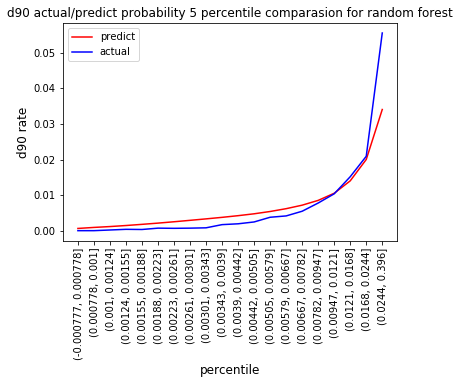

In [145]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.plot(data2['predicted'],c= 'r', label='predict')
ax.plot(data2['Actual'], c= 'b', label = 'actual')
ticks=ax.set_xticks(np.arange(0,20))
labels=ax.set_xticklabels(['(-0.000777, 0.000778]','(0.000778, 0.001]','(0.001, 0.00124]','(0.00124, 0.00155]',
                           '(0.00155, 0.00188]','(0.00188, 0.00223]','(0.00223, 0.00261]','(0.00261, 0.00301]',
                           '(0.00301, 0.00343]','(0.00343, 0.0039]','(0.0039, 0.00442]','(0.00442, 0.00505]',
                           '(0.00505, 0.00579]','(0.00579, 0.00667]','(0.00667, 0.00782]','(0.00782, 0.00947]',
                           '(0.00947, 0.0121]','(0.0121, 0.0168]','(0.0168, 0.0244]','(0.0244, 0.396]'],rotation=90)
plt.title("d90 actual/predict probability 5 percentile comparasion for random forest")
plt.legend()
plt.xlabel('percentile', fontsize =12)
plt.ylabel('d90 rate',fontsize =12)
#plt.savefig('percentile_compare_2018_rf.png')
plt.show()

## xgboost

In [146]:
val_xgb['d90_flag'] = y 
e = val_xgb.groupby(pd.qcut(val_xgb['prob'],20,duplicates = 'drop'))['prob'].mean()
f = val_xgb.groupby(pd.qcut(val_xgb['prob'],20,duplicates = 'drop'))['d90_flag'].mean()
data3=pd.DataFrame({'predicted':e,'Actual':f})
data3=data3.reset_index()
data3

,prob,predicted,Actual
0,"(-0.000833, 0.000518]",0.000409,0.000047
1,"(0.000518, 0.000665]",0.000592,0.000282
2,"(0.000665, 0.000828]",0.000743,0.000235
3,"(0.000828, 0.00101]",0.000921,0.000517
4,"(0.00101, 0.00123]",0.001119,0.000517
5,"(0.00123, 0.00147]",0.001348,0.000798
6,"(0.00147, 0.00175]",0.001609,0.001456
7,"(0.00175, 0.00206]",0.001904,0.001503
8,"(0.00206, 0.00244]",0.002247,0.001691
9,"(0.00244, 0.00287]",0.002647,0.002068


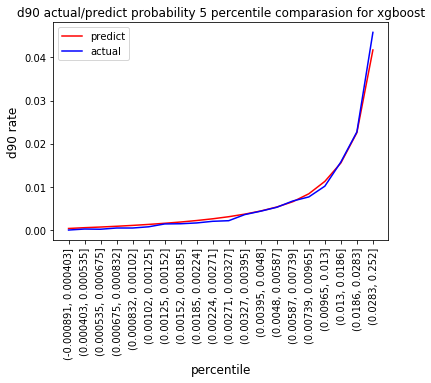

In [147]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.plot(data3['predicted'],c= 'r', label='predict')
ax.plot(data3['Actual'], c= 'b', label = 'actual')
ticks=ax.set_xticks(np.arange(0,20))
labels=ax.set_xticklabels(['(-0.000891, 0.000403]','(0.000403, 0.000535]','(0.000535, 0.000675]','(0.000675, 0.000832]',
                           '(0.000832, 0.00102]','(0.00102, 0.00125]','(0.00125, 0.00152]','(0.00152, 0.00185]',
                           '(0.00185, 0.00224]','(0.00224, 0.00271]','(0.00271, 0.00327]','(0.00327, 0.00395]',
                           '(0.00395, 0.0048]','(0.0048, 0.00587]','(0.00587, 0.00739]','(0.00739, 0.00965]',
                           '(0.00965, 0.013]','(0.013, 0.0186]','(0.0186, 0.0283]','(0.0283, 0.252]'],rotation=90)
plt.title("d90 actual/predict probability 5 percentile comparasion for xgboost")
plt.legend()
plt.xlabel('percentile', fontsize =12)
plt.ylabel('d90 rate',fontsize =12)
#plt.savefig('percentile_compare_2018_xgboost.png')
plt.show()

## Logistic with spine

In [98]:
val_logsp.head()
lg1 = val_logsp.groupby(pd.qcut(val_logsp['prob'],20,duplicates = 'drop'))['prob'].mean()
lg2= val_logsp.groupby(pd.qcut(val_logsp['prob'],20,duplicates = 'drop'))['d90_flag'].mean()
data4=pd.DataFrame({'predicted':lg1,'Actual':lg2})
data4=data4.reset_index()
data4

,prob,predicted,Actual
0,"(-0.0009187, 0.000477]",0.000324,0.000470
1,"(0.000477, 0.000773]",0.000634,0.000939
2,"(0.000773, 0.000987]",0.000884,0.001033
3,"(0.000987, 0.00119]",0.001089,0.001080
4,"(0.00119, 0.00142]",0.001300,0.001315
5,"(0.00142, 0.00169]",0.001547,0.001550
6,"(0.00169, 0.00202]",0.001850,0.001879
7,"(0.00202, 0.00243]",0.002220,0.002208
8,"(0.00243, 0.00294]",0.002680,0.001926
9,"(0.00294, 0.00357]",0.003243,0.003429


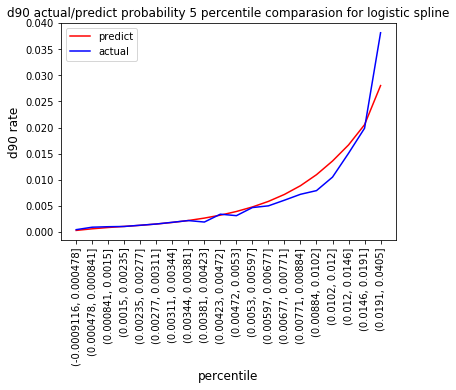

In [99]:
x=data['prob']
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.plot(data4['predicted'],c= 'r', label='predict')
ax.plot(data4['Actual'], c= 'b', label = 'actual')
ticks=ax.set_xticks(np.arange(0,20))
labels=ax.set_xticklabels(x,rotation=90)
plt.title("d90 actual/predict probability 5 percentile comparasion for logistic spline")
plt.legend()
plt.xlabel('percentile', fontsize =12)
plt.ylabel('d90 rate',fontsize =12)
#plt.savefig('percentile_compare_2018_logistic_spline.png')
plt.show()

## Logistic model with all dummy variable

In [153]:
d1 = val_log_dummy.groupby(pd.qcut(val_log_dummy['prob'],20,duplicates = 'drop'))['prob'].mean()
d2= val_log_dummy.groupby(pd.qcut(val_log_dummy['prob'],20,duplicates = 'drop'))['d90_flag'].mean()
lg_dummy=pd.DataFrame({'predicted':d1,'Actual':d2})
lg_dummy=lg_dummy.reset_index()


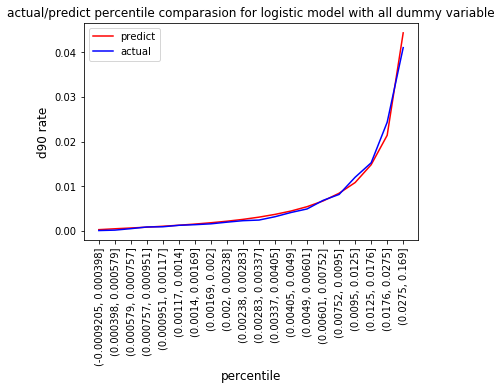

In [154]:
ddd=lg_dummy['prob']
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.plot(lg_dummy['predicted'],c= 'r', label='predict')
ax.plot(lg_dummy['Actual'], c= 'b', label = 'actual')
ticks=ax.set_xticks(np.arange(0,20))
labels=ax.set_xticklabels(ddd,rotation=90)
plt.title("actual/predict percentile comparasion for logistic model with all dummy variable")
plt.legend()
plt.xlabel('percentile', fontsize =12)
plt.ylabel('d90 rate',fontsize =12)
#plt.savefig('percentile_compare_2018_logistic_with_all_dummy.png')
plt.show()

From above plot, traditional logit model and logit with spline didn't follow the actual value well in high default and low default probability area. But logit model with all dummy variables follow the acutal trend well. 

# Out of Sample validation

## Test the models on 2016,2015,2014 loan data pool

In [304]:
df2016=pd.read_csv(r'C:\Users\yusha\OneDrive\Desktop\Intern\d60_90_flag2016q3.csv')
df2014=pd.read_csv(r'C:\Users\yusha\OneDrive\Desktop\Intern\d60_90_flag2014q3.csv')
df2015=pd.read_csv(r'C:\Users\yusha\OneDrive\Desktop\Intern\d60_90_flag2015q4.csv')

Clean the data

In [305]:

def clean(df2):
    df2 = df2.drop(columns=['loan_identifier','origination_channel','seller_name','d60_flag',
                          'first_payment_date','origination_date','product_type','mortgage_insurance_type','relocation_mortgage',
                         'property_state','zip_code_short'])
    
    df2['loan_credit_score_orig'] = df2.apply(lambda x: min(x['borrower_credit_score_orig'],x['coborrower_credit_score_orig']), axis=1)
    df2 = df2.drop(columns=['primary_mortgage_insurance_percent',
                            'borrower_credit_score_orig','coborrower_credit_score_orig'])
    df2.dropna(axis=0, how='any',inplace=True)
    df2 = df2.drop(columns = ['original_ltv'])
    df2['number_of_borrowers'] = df2['number_of_borrowers'].apply(lambda x: '1' if x == 1 else '2+')
    df2['number_of_units'] = df2['number_of_units'].apply(lambda x: '1' if x == 1 else '2+')

    categorical_cols = ['number_of_borrowers',
                        'first_time_home_buyer', 'loan_purpose', 'property_type', 
                        'number_of_units','occupancy_type']

    df2=pd.get_dummies(df2,
                       prefix_sep='_',
                       drop_first=False,
                       columns=categorical_cols)
    try:
        df2 = df2.drop(columns = ['first_time_home_buyer_N','first_time_home_buyer_U'])
    except: df2 = df2.drop(columns = ['first_time_home_buyer_N'])
        
    return df2

In [306]:
df2014 = clean(df2014)
df2015 = clean(df2015)
df2016 = clean(df2016)

In [307]:
df2014.head()

,original_interest_rate,original_upb,original_loan_term,original_cltv,original_dti,d90_flag,loan_credit_score_orig,number_of_borrowers_1,number_of_borrowers_2+,first_time_home_buyer_Y,...,property_type_CO,property_type_CP,property_type_MH,property_type_PU,property_type_SF,number_of_units_1,number_of_units_2+,occupancy_type_I,occupancy_type_P,occupancy_type_S
0,4.25,220000,240,80,42.0,0,785.0,0,1,0,...,0,0,0,0,1,1,0,0,1,0
1,3.50,152000,180,92,41.0,0,667.0,0,1,0,...,0,0,0,1,0,1,0,0,1,0
2,4.25,87000,360,74,44.0,0,744.0,1,0,0,...,0,0,0,0,1,1,0,0,1,0
3,4.50,224000,360,80,27.0,0,637.0,1,0,1,...,0,0,0,0,1,1,0,0,1,0
4,3.50,417000,180,65,35.0,0,758.0,1,0,0,...,0,0,0,1,0,1,0,0,1,0


In [282]:
df2016.head()

,original_interest_rate,original_upb,original_loan_term,original_cltv,original_dti,d90_flag,loan_credit_score_orig,number_of_borrowers_1,number_of_borrowers_2+,first_time_home_buyer_Y,...,property_type_CO,property_type_CP,property_type_MH,property_type_PU,property_type_SF,number_of_units_1,number_of_units_2+,occupancy_type_I,occupancy_type_P,occupancy_type_S
0,3.875,238000,360,52,29.0,0,782.0,0,1,0,...,0,0,0,0,1,1,0,0,1,0
1,3.500,125000,360,77,18.0,0,775.0,0,1,1,...,0,0,0,0,1,1,0,0,1,0
2,3.625,136000,360,80,47.0,0,767.0,0,1,0,...,0,0,0,0,1,1,0,0,1,0
3,3.625,353000,360,95,37.0,0,723.0,1,0,1,...,0,0,0,1,0,1,0,0,1,0
4,3.500,339000,360,93,27.0,0,775.0,0,1,1,...,0,0,0,0,1,1,0,0,1,0


In [283]:
df2015.head()

,original_interest_rate,original_upb,original_loan_term,original_cltv,original_dti,d90_flag,loan_credit_score_orig,number_of_borrowers_1,number_of_borrowers_2+,first_time_home_buyer_Y,...,property_type_CO,property_type_CP,property_type_MH,property_type_PU,property_type_SF,number_of_units_1,number_of_units_2+,occupancy_type_I,occupancy_type_P,occupancy_type_S
0,3.000,265000,180,30.0,29.0,0,816.0,0,1,0,...,0,0,0,0,1,1,0,0,1,0
1,4.000,285000,360,75.0,40.0,0,796.0,1,0,1,...,1,0,0,0,0,1,0,0,1,0
2,3.875,210000,360,95.0,29.0,0,790.0,0,1,0,...,0,0,0,0,1,1,0,0,1,0
3,4.375,165000,360,69.0,36.0,0,786.0,0,1,0,...,0,0,0,1,0,1,0,0,1,0
4,4.250,188000,360,95.0,44.0,0,792.0,1,0,0,...,0,0,0,1,0,1,0,0,1,0


In [308]:
def validation(df,year):     
    df.reset_index(inplace=True, drop = True)
    y = df['d90_flag']
    X = df.drop(columns = ['d90_flag'])

    ##logit model
    val_log = pd.concat([X,pd.DataFrame(logit_model.predict_proba(X))[[1]]],axis = 1)
    val_log.rename(columns = {1:'prob'}, inplace = True)

    ##logit model with sp
    df_sp = df.copy()

    df_sp['original_interest_rate_4.1'] = df_sp['original_interest_rate'].apply(lambda x: max(x-4.1,0))
    df_sp['original_interest_rate_5.0'] = df_sp['original_interest_rate'].apply(lambda x: max(x-5.0,0))

    df_sp['original_cltv_85'] = df_sp['original_cltv'].apply(lambda x: max(x-85,0))
    df_sp['original_cltv_95'] = df_sp['original_cltv'].apply(lambda x: max(x-95,0))

    df_sp['loan_credit_score_orig_695'] = df_sp['loan_credit_score_orig'].apply(lambda x: max(x-695,0))
    df_sp['loan_credit_score_orig_720'] = df_sp['loan_credit_score_orig'].apply(lambda x: max(x-720,0))

    y_sp = df_sp['d90_flag']
    X_sp = df_sp.drop(columns = ['d90_flag'])
    val_logsp = pd.concat([X_sp,pd.DataFrame(logit_model_sp.predict_proba(X_sp))[[1]]],axis = 1)
    val_logsp.rename(columns = {1:'prob'}, inplace = True)
    
    ##random forest
    val_rf = pd.concat([X,pd.DataFrame(rf_model.predict_proba(X))[[1]]],axis = 1)
    val_rf.rename(columns = {1:'prob'}, inplace = True)

    ##xgboost
    val_xgb = pd.concat([X,pd.DataFrame(xgb_model.predict_proba(X))[[1]]],axis = 1)
    val_xgb.rename(columns = {1:'prob'}, inplace = True)
    
    ##put together and visualize
    continuous = ['original_interest_rate', 'original_upb', 'original_cltv', 
             'original_dti', 'loan_credit_score_orig']
    for col in continuous:
        plt.subplot(111)
        a = val_log.groupby(pd.qcut(val_log[col],20,duplicates = 'drop'))[[col, 'prob']].mean()
        plt.plot(a[col],a['prob'], c= 'y', label='logit_predict')

        c = val_logsp.groupby(pd.qcut(val_logsp[col],20,duplicates = 'drop'))[[col, 'prob']].mean()
        plt.plot(c[col],c['prob'], c= 'g', label='logit_sp_predict')

        d = val_xgb.groupby(pd.qcut(val_xgb[col],20,duplicates = 'drop'))[[col, 'prob']].mean()
        plt.plot(d[col],d['prob'], c= 'orange', label='xbg_predict')

        e = val_rf.groupby(pd.qcut(val_rf[col],20,duplicates = 'drop'))[[col, 'prob']].mean()
        plt.plot(e[col],e['prob'], c= 'b', label='rf_predict')


        b = df.groupby(pd.qcut(df[col],20,duplicates = 'drop'))[[col, 'd90_flag']].mean()
        plt.plot(b[col],b['d90_flag'], c= 'r', label = 'observed')

        #plt.savefig("figs/bivariate_analysis/count_vs_" + col + ".png")
        plt.title("Predicted vs Observed D90+ Rate by " + col)
        plt.legend()
        plt.xlabel(col, fontsize =12)
        plt.ylabel('d90 rate',fontsize =12)
        plt.show()
    
    category = [['number_of_borrowers_1', 'number_of_borrowers_2+'], ['loan_purpose_C',
       'loan_purpose_P', 'loan_purpose_R'], ['property_type_CO',
       'property_type_CP', 'property_type_MH', 'property_type_PU',
       'property_type_SF'], ['number_of_units_1', 'number_of_units_2+'],
       ['occupancy_type_I', 'occupancy_type_P', 'occupancy_type_S']]
    
    for li in category:
        med = {}
        med['observed'] = []
        med['logit'] = []
        med['logit_sp'] = []
        med['xgb'] = []
        med['rf'] = []
        for i in li:
            med['observed'].append(df.groupby([i],as_index=False)[['d90_flag']].mean().iloc[1,1])
            med['logit'].append(val_log[val_log[i]==1]['prob'].mean())
            med['logit_sp'].append(val_logsp[val_logsp[i]==1]['prob'].mean())
            med['xgb'].append(val_xgb[val_xgb[i]==1]['prob'].mean())
            med['rf'].append(val_rf[val_rf[i]==1]['prob'].mean()) 


        df_med = pd.DataFrame(med, index=li) 

        plt.figure()
        df_med.plot(kind = 'bar',color = ['r','y','g','orange','b'], figsize = (10,5))
        plt.title("Predicted vs Observed D90+ Rate by "+li[0][:-3])
        plt.ylabel('d90 rate',fontsize =12)
        #plt.savefig("figs/first/d90_vs_" + li[0][:-3] + ".png")
        plt.show()
        
    return     

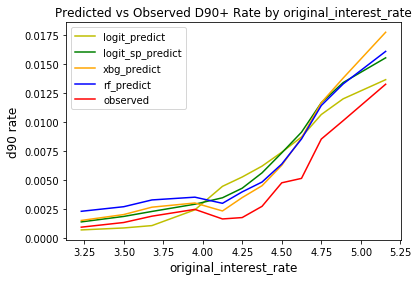

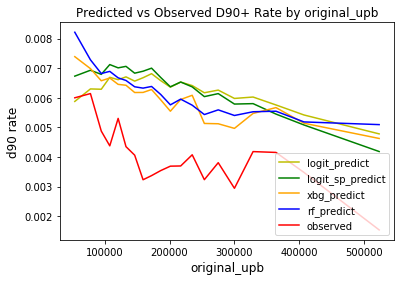

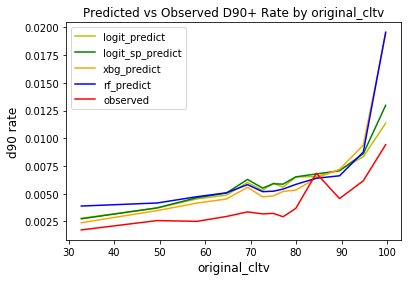

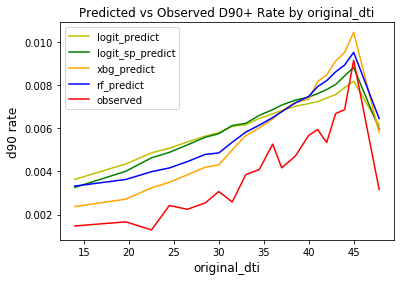

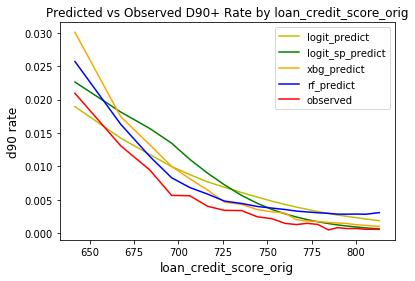

<Figure size 432x288 with 0 Axes>

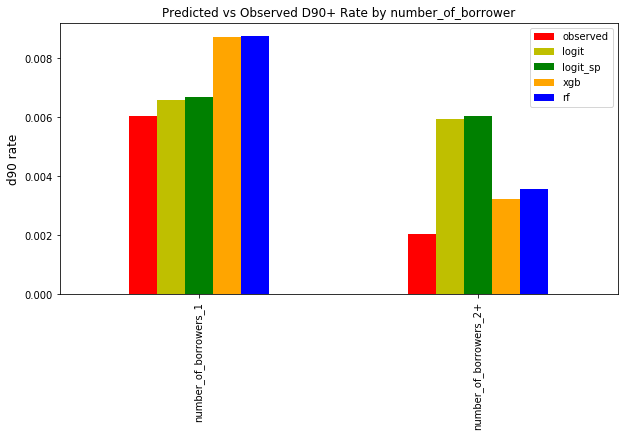

<Figure size 432x288 with 0 Axes>

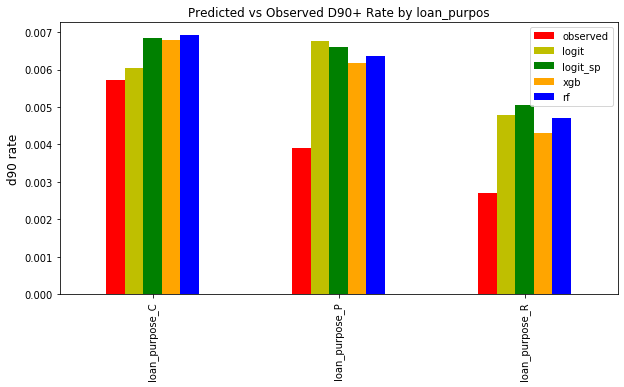

<Figure size 432x288 with 0 Axes>

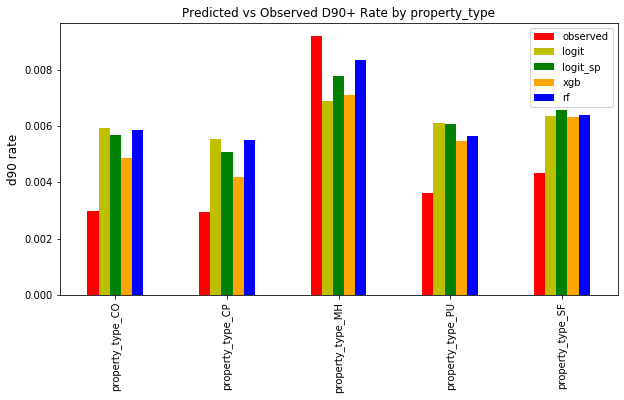

<Figure size 432x288 with 0 Axes>

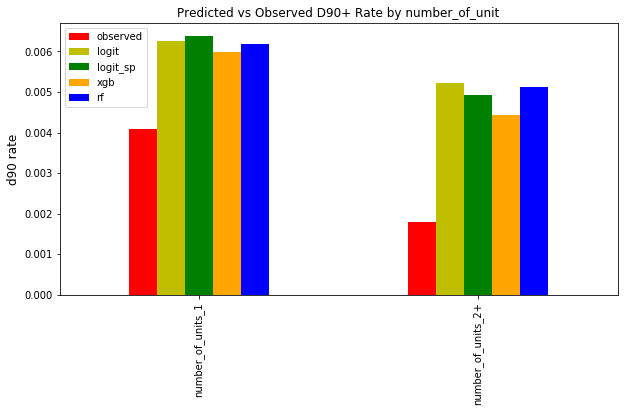

<Figure size 432x288 with 0 Axes>

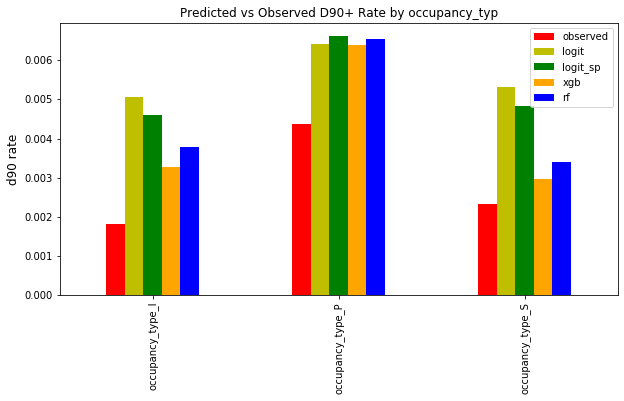

In [309]:
validation(df2014, 2014)

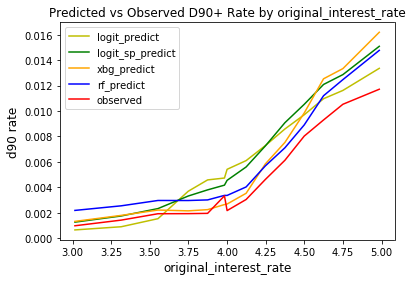

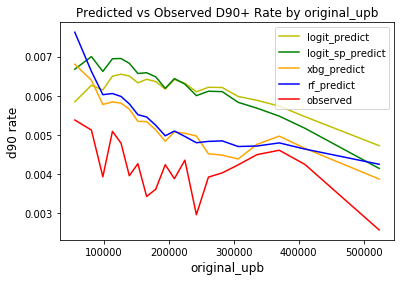

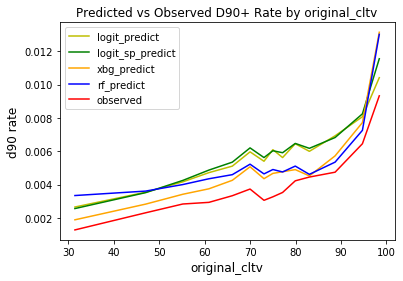

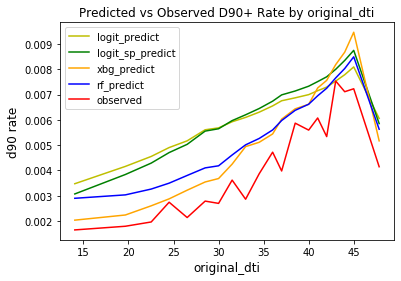

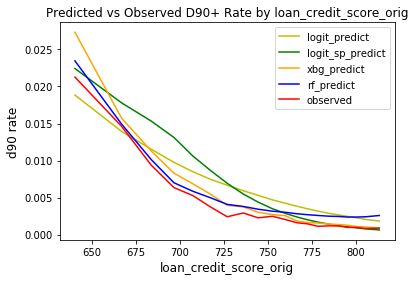

<Figure size 432x288 with 0 Axes>

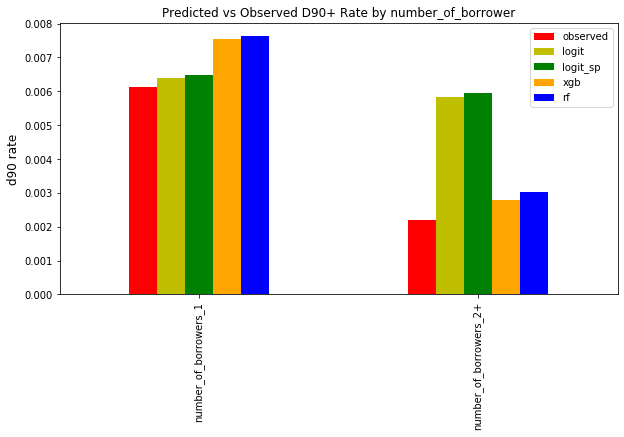

<Figure size 432x288 with 0 Axes>

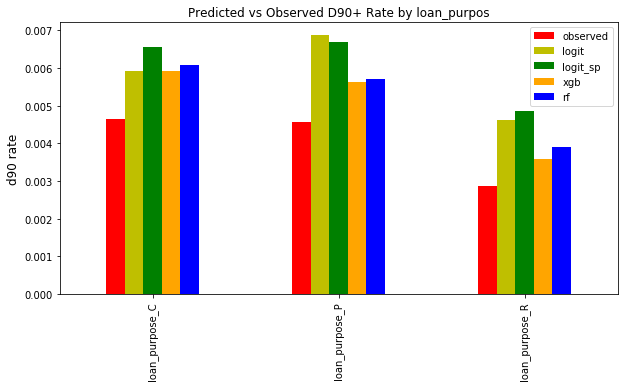

<Figure size 432x288 with 0 Axes>

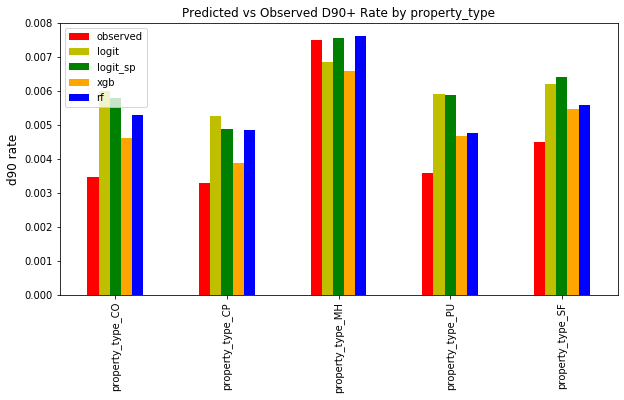

<Figure size 432x288 with 0 Axes>

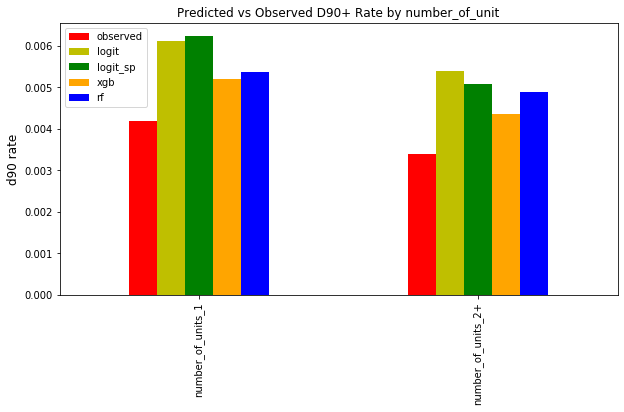

<Figure size 432x288 with 0 Axes>

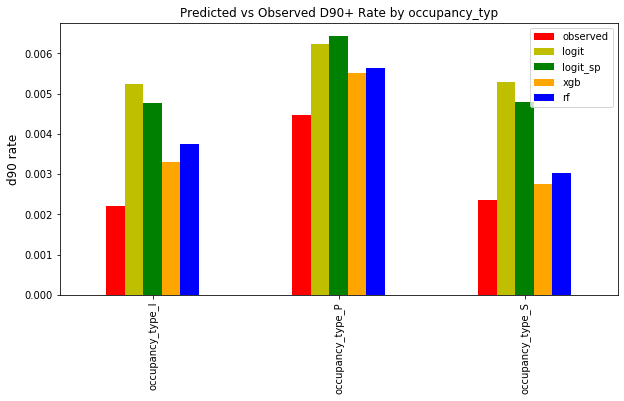

In [286]:
validation(df2015, 2015)

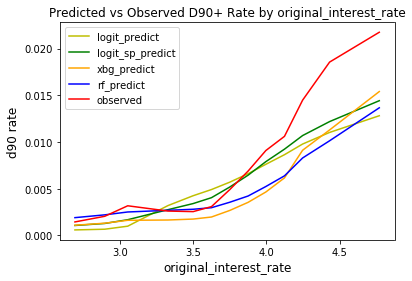

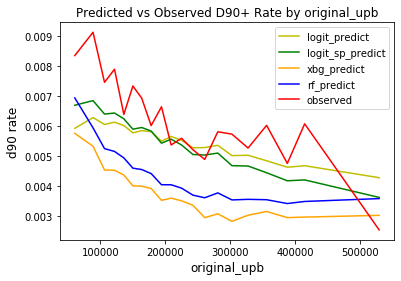

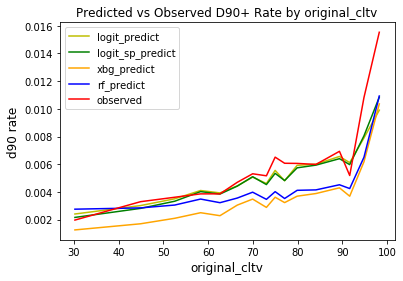

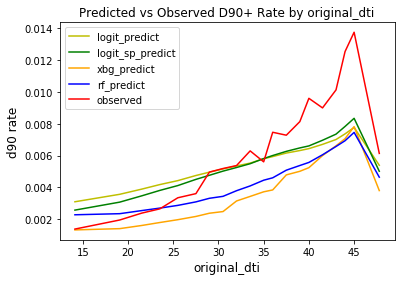

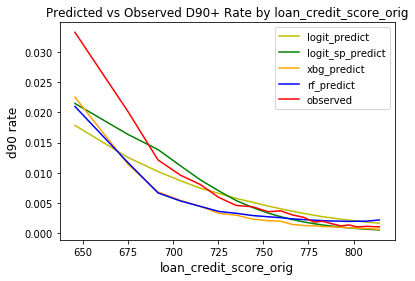

<Figure size 432x288 with 0 Axes>

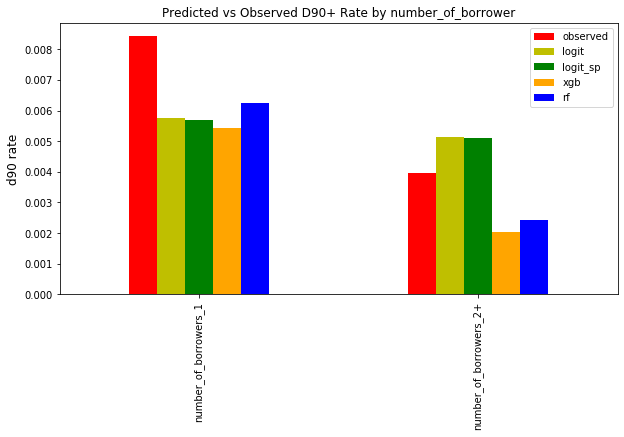

<Figure size 432x288 with 0 Axes>

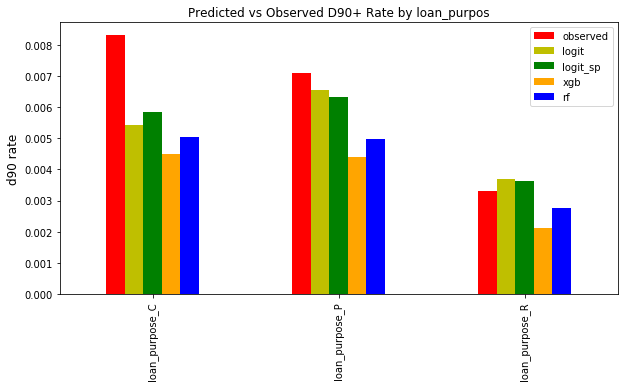

<Figure size 432x288 with 0 Axes>

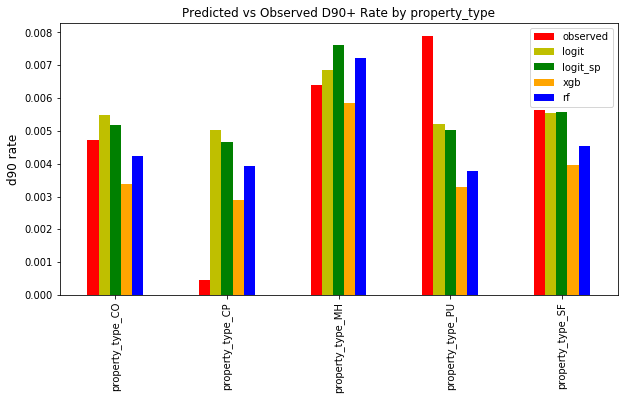

<Figure size 432x288 with 0 Axes>

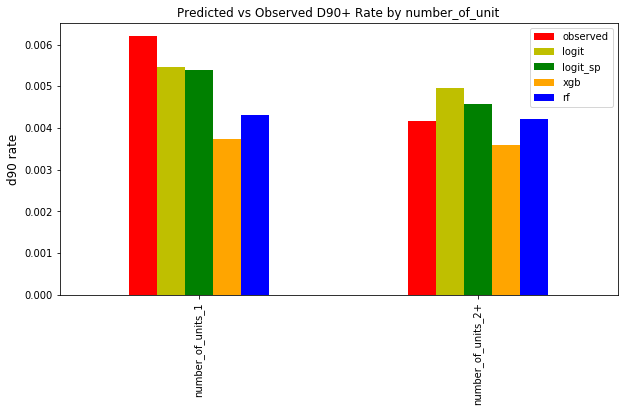

<Figure size 432x288 with 0 Axes>

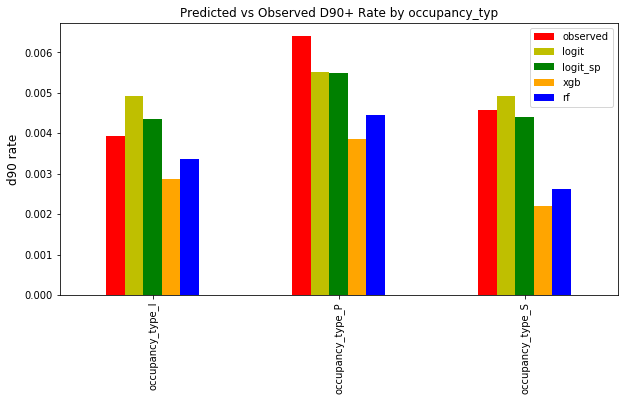

In [287]:
validation(df2016, 2016)

TRY transfer continuous variable to categorical variable for 2014 loan pool

In [310]:
def dummy_clean(df):
    df_new=df.copy()
    df_new['loan_credit_score_orig']=pd.cut(df_new['loan_credit_score_orig'],bins=[0,620,660,700,740,780,850],right=True,duplicates='drop')
    df_new['original_upb']=pd.cut(df_new['original_upb'],bins=[0,85000,110000,125000,150000,175000,200000,417000,1500000],right=True,duplicates='drop')
    df_new['original_interest_rate']=pd.cut(df_new['original_interest_rate'],bins=[0,3,4,5,6,8],right=True,duplicates='drop')
    df_new['original_cltv']=pd.cut(df_new['original_cltv'],bins=[0,60,70,80,90,120],right=True,duplicates='drop')
    df_new['original_dti']=pd.cut(df_new['original_dti'],bins=[0,20,30,40,45,100],right=True,duplicates='drop')
    df_new['original_loan_term']=pd.cut(df_new['original_loan_term'],bins=[0,120,180,240,300,360],right=True,duplicates='drop')
    df_all_dummy=df_new.copy()
    continius_variables = ['original_interest_rate', 'original_upb', 'original_cltv', 
             'original_dti', 'loan_credit_score_orig','original_loan_term']
    df_all_dummy=pd.get_dummies(df_all_dummy,prefix_sep='_',drop_first=False,columns=continius_variables)
    return df_all_dummy,df_new

In [311]:
df_dummy_2014,df_new_2014=dummy_clean(df2014)
df_dummy_2015,df_new_2015=dummy_clean(df2015)
df_dummy_2016,df_new_2016=dummy_clean(df2016)

In [318]:
def dummy_validation(df,df_new,year):
  
    df.reset_index(inplace=True, drop = True)
    y = df['d90_flag']
    X=df.drop(columns = ['d90_flag'])
    
  
    val_dummy = pd.concat([df_new,pd.DataFrame(logit_model_dummy.predict_proba(X))[[1]]],axis = 1)
    val_dummy.rename(columns = {1:'prob'}, inplace = True)

    continius = ['original_interest_rate', 'original_upb', 'original_cltv', 
            'original_dti', 'loan_credit_score_orig']

    for col in continius:
        plt.subplot(111)
        a =val_dummy.groupby(col)[[col, 'prob']].mean().reset_index()
        x=a[col].astype(str)
        plt.plot(x,a['prob'],c= 'y', label='logit_dummy_predict')
    
        c = val_dummy.groupby(col)[[col, 'd90_flag']].mean().reset_index()
        x1=a[col].astype(str)
        plt.plot(x1,c['d90_flag'], c= 'g', label='logit_dummy_actual')
    
        plt.title("Predicted vs Observed D90+ Rate by " + col)
        plt.legend()
        plt.xlabel(col, fontsize =12)
        plt.ylabel('d90 rate',fontsize =12)
        plt.show()
    return  

Validation on 2014 data for logistical regression model with all dummy varailbes

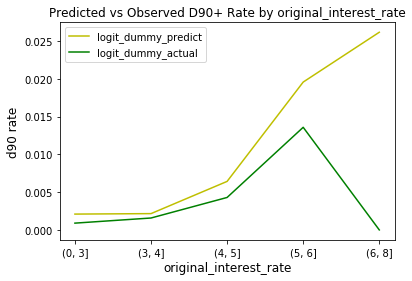

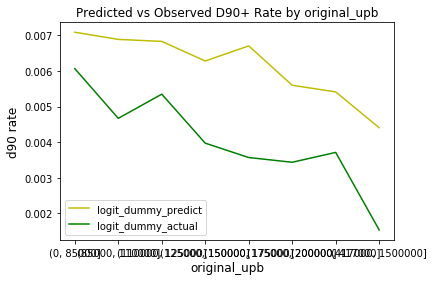

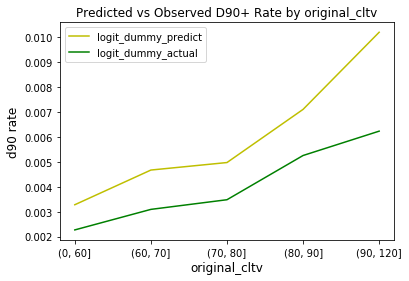

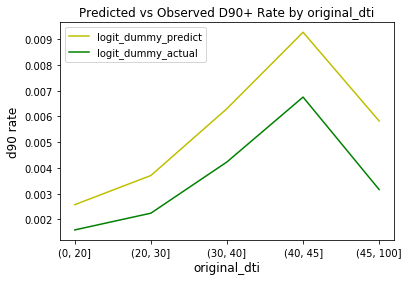

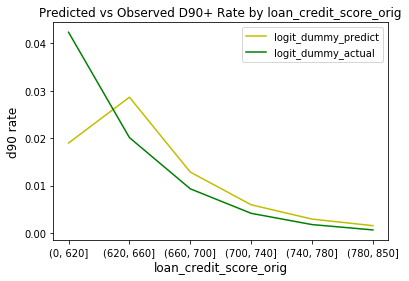

In [319]:
dummy_validation(df_dummy_2014,df_new_2014,2014)

# Model Power Comparison

## Model Comparion on 2018Q1 loan pool

In [288]:
model_list

{'logit_model': LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='warn', n_jobs=None, penalty='l2',
                    random_state=None, solver='warn', tol=0.0001, verbose=0,
                    warm_start=False),
 'logit_model_sp': LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='warn', n_jobs=None, penalty='l2',
                    random_state=None, solver='warn', tol=0.0001, verbose=0,
                    warm_start=False),
 'xgb_model': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
               importance_type='gain', interaction_constraints='',
               learning_rate=0.1, max_delta_step=0, max_depth=4,
              

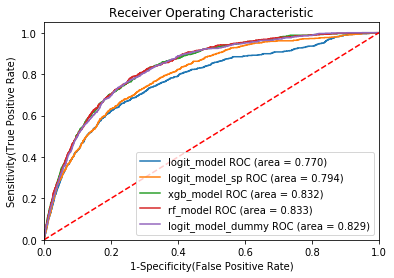

In [289]:
from sklearn import metrics

plt.figure()

# Below for loop iterates through your models list
for name, model in model_list.items():
    if name == 'logit_model_sp':
        a = X_test_sp
    elif name=='logit_model_dummy':
        a=X_test_dummy
    else: a = X_test
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(a)[:,1])
# Calculate Area under the curve to display on the plot
    auc = metrics.roc_auc_score(y_test,model.predict_proba(a)[:,1])
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.3f)' % (name, auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
#plt.savefig('ROC_2018.png')
plt.show()   # Display

From the ROC plot , the random forest model and XGboost model have the best performance than other models.

## Model comparion  on 2014, 2015,2016 datasets.

In [320]:
def comparision(df):
    df.reset_index(inplace=True, drop = True)
    y = df['d90_flag']
    X = df.drop(columns = ['d90_flag'])
    
    df_sp = df.copy()

    df_sp['original_interest_rate_4.1'] = df_sp['original_interest_rate'].apply(lambda x: max(x-4.1,0))
    df_sp['original_interest_rate_5.0'] = df_sp['original_interest_rate'].apply(lambda x: max(x-5.0,0))

    df_sp['original_cltv_85'] = df_sp['original_cltv'].apply(lambda x: max(x-85,0))
    df_sp['original_cltv_95'] = df_sp['original_cltv'].apply(lambda x: max(x-95,0))

    df_sp['loan_credit_score_orig_695'] = df_sp['loan_credit_score_orig'].apply(lambda x: max(x-695,0))
    df_sp['loan_credit_score_orig_720'] = df_sp['loan_credit_score_orig'].apply(lambda x: max(x-720,0))

    y_sp = df_sp['d90_flag']
    X_sp = df_sp.drop(columns = ['d90_flag'])
    
    # transfer all continuouse variable to categorical variable
    X_dummy,X_new=dummy_clean(df)
    X_dummy=X_dummy.drop(columns = ['d90_flag'])
    # Below for loop iterates through your models list
    for name, model in model_list.items():
        if name == 'logit_model_sp':
            a = X_sp
        elif name == 'logit_model_dummy':  
             a=X_dummy 
        else: a = X
    # Compute False postive rate, and True positive rate
        fpr, tpr, thresholds = metrics.roc_curve(y, model.predict_proba(a)[:,1])
    # Calculate Area under the curve to display on the plot
        auc = metrics.roc_auc_score(y,model.predict_proba(a)[:,1])
    # Now, plot the computed values
        plt.plot(fpr, tpr, label='%s ROC (area = %0.3f)' % (name, auc))
    # Custom settings for the plot 
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1-Specificity(False Positive Rate)')
    plt.ylabel('Sensitivity(True Positive Rate)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()   # Display
    return 

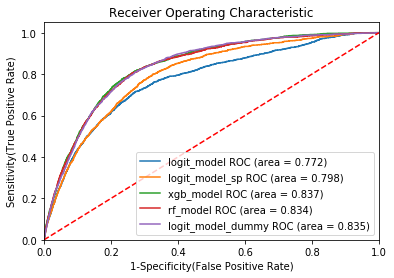

In [321]:
comparision(df2014)

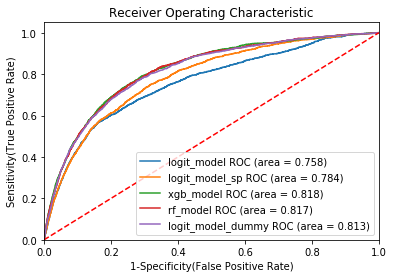

In [322]:
comparision(df2015)

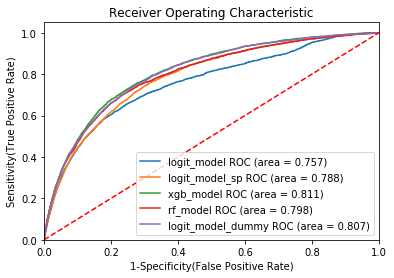

In [323]:
comparision(df2016)

For out of sample validation, we can see XGboost model's auc is highest

## 5 percentile comparision between predict probability and actual for  2014Q3 loan pool 

In [324]:
y = df2014['d90_flag']
X = df2014.drop(columns = ['d90_flag'])
X_dummy=df_dummy_2014.drop(columns = ['d90_flag'])
 ##logit model
val_log_2014 = pd.concat([X,pd.DataFrame(logit_model.predict_proba(X))[[1]]],axis = 1)
val_log_2014.rename(columns = {1:'prob'}, inplace = True)
    
 ##random forest
val_rf_2014 = pd.concat([X,pd.DataFrame(rf_model.predict_proba(X))[[1]]],axis = 1)
val_rf_2014.rename(columns = {1:'prob'}, inplace = True)

##xgboost
val_xgb_2014 = pd.concat([X,pd.DataFrame(xgb_model.predict_proba(X))[[1]]],axis = 1)
val_xgb_2014.rename(columns = {1:'prob'}, inplace = True)

# logit_all_dummy
val_lg_dummy_2014=pd.concat([X_dummy,pd.DataFrame(logit_model_dummy.predict_proba(X_dummy))[[1]]],axis = 1)
val_lg_dummy_2014.rename(columns = {1:'prob'}, inplace = True)
   

###  logistic model

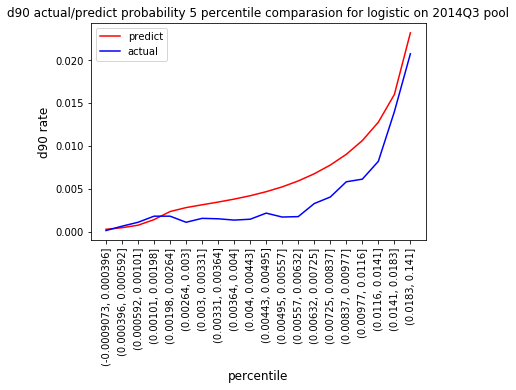

In [325]:
val_log_2014['d90_flag'] = y 
l1 = val_log_2014.groupby(pd.qcut(val_log_2014['prob'],20,duplicates = 'drop'))['prob'].mean()
l2= val_log_2014.groupby(pd.qcut(val_log_2014['prob'],20,duplicates = 'drop'))['d90_flag'].mean()
data_log=pd.DataFrame({'predicted':l1,'Actual':l2})
data_log=data_log.reset_index()
x=data_log['prob']
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.plot(data_log['predicted'],c= 'r', label='predict')
ax.plot(data_log['Actual'], c= 'b', label = 'actual')
ticks=ax.set_xticks(np.arange(0,20))
labels=ax.set_xticklabels(x,rotation=90)
plt.title("d90 actual/predict probability 5 percentile comparasion for logistic on 2014Q3 pool")
plt.legend()
plt.xlabel('percentile', fontsize =12)
plt.ylabel('d90 rate',fontsize =12)
#plt.savefig('percentile_compare_2014_logit.png')
plt.show()

### Random forest

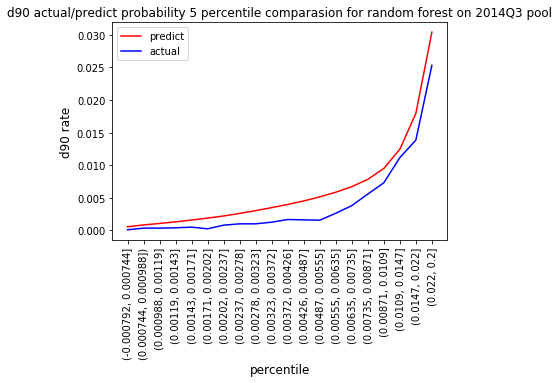

In [331]:
val_rf_2014 ['d90_flag'] = y 
r1 = val_rf_2014.groupby(pd.qcut(val_rf_2014 ['prob'],20,duplicates = 'drop'))['prob'].mean()
r2= val_rf_2014.groupby(pd.qcut(val_rf_2014['prob'],20,duplicates = 'drop'))['d90_flag'].mean()
data_rf=pd.DataFrame({'predicted':r1,'Actual':r2})
data_rf=data_rf.reset_index()
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.plot(data_rf['predicted'],c= 'r', label='predict')
ax.plot(data_rf['Actual'], c= 'b', label = 'actual')
ticks=ax.set_xticks(np.arange(0,20))
labels=ax.set_xticklabels(['(-0.000792, 0.000744]','(0.000744, 0.000988])','(0.000988, 0.00119]','(0.00119, 0.00143]','(0.00143, 0.00171]',
                           '(0.00171, 0.00202]','(0.00202, 0.00237]','(0.00237, 0.00278]','(0.00278, 0.00323]',
                           '(0.00323, 0.00372]','(0.00372, 0.00426]','(0.00426, 0.00487]','(0.00487, 0.00555]',
                           '(0.00555, 0.00635]','(0.00635, 0.00735]','(0.00735, 0.00871]','(0.00871, 0.0109]',
                           '(0.0109, 0.0147]','(0.0147, 0.022]','(0.022, 0.2]'],rotation=90)
plt.title("d90 actual/predict probability 5 percentile comparasion for random forest on 2014Q3 pool")
plt.legend()
plt.xlabel('percentile', fontsize =12)
plt.ylabel('d90 rate',fontsize =12)
plt.savefig('percentile_compare_rf_2014.png')
plt.show()

### XGboost

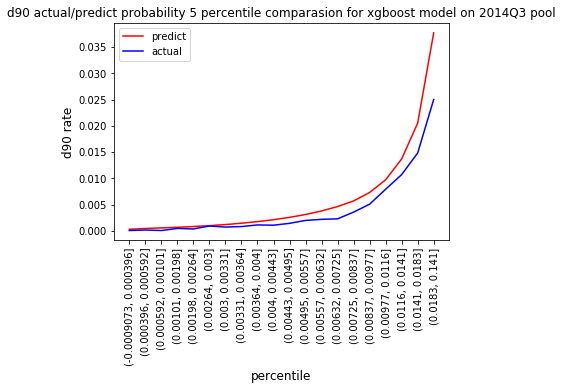

In [327]:
val_xgb_2014['d90_flag'] = y 
xg1 =val_xgb_2014.groupby(pd.qcut(val_xgb_2014['prob'],20,duplicates = 'drop'))['prob'].mean()
xg2= val_xgb_2014.groupby(pd.qcut(val_xgb_2014['prob'],20,duplicates = 'drop'))['d90_flag'].mean()
data_xgb=pd.DataFrame({'predicted':xg1,'Actual':xg2})
data_xgb=data_xgb.reset_index()
data_xgb
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.plot(data_xgb['predicted'],c= 'r', label='predict')
ax.plot(data_xgb['Actual'], c= 'b', label = 'actual')
ticks=ax.set_xticks(np.arange(0,20))
labels=ax.set_xticklabels(x,rotation=90)   
plt.title("d90 actual/predict probability 5 percentile comparasion for xgboost model on 2014Q3 pool")
plt.legend()
plt.xlabel('percentile', fontsize =12)
plt.ylabel('d90 rate',fontsize =12)
plt.savefig('percentile_compare_xgb_2014.png')
plt.show()

### Logistic model with all dummy

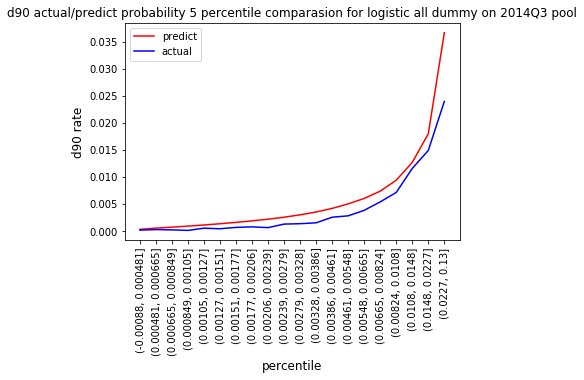

In [330]:
val_lg_dummy_2014['d90_flag'] = y 
l1 = val_lg_dummy_2014.groupby(pd.qcut(val_lg_dummy_2014['prob'],20,duplicates = 'drop'))['prob'].mean()
l2= val_lg_dummy_2014.groupby(pd.qcut(val_lg_dummy_2014['prob'],20,duplicates = 'drop'))['d90_flag'].mean()
data_dummy=pd.DataFrame({'predicted':l1,'Actual':l2})
data_dummy=data_dummy.reset_index()
x=data_dummy['prob']
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.plot(data_dummy['predicted'],c= 'r', label='predict')
ax.plot(data_dummy['Actual'], c= 'b', label = 'actual')
ticks=ax.set_xticks(np.arange(0,20))
labels=ax.set_xticklabels(x,rotation=90)
plt.title("d90 actual/predict probability 5 percentile comparasion for logistic all dummy on 2014Q3 pool")
plt.legend()
plt.xlabel('percentile', fontsize =12)
plt.ylabel('d90 rate',fontsize =12)
#plt.savefig('percentile_compare_2014_logit.png')
plt.show()

From 5 percentile prob comparision, logistic model with all dummy varialbes and XGboost model show better result than others

# Feature importance

In [333]:
def feature(name, model, X_train):
    series = pd.Series(model.feature_importances_, index=X_train.columns).nlargest(len(X_train.columns))
    series.plot(kind='barh')
    plt.title("Feature Importance of "+name, fontsize=15)
    plt.show()

In [334]:
def logit_pvalue(model, x):
    """ Calculate z-scores for scikit-learn LogisticRegression.
    parameters:
        model: fitted sklearn.linear_model.LogisticRegression with intercept and large C
        x:     matrix on which the model was fit
    This function uses asymtptics for maximum likelihood estimates.
    """
    p = model.predict_proba(x)
    n = len(p)
    m = len(model.coef_[0]) + 1
    coefs = np.concatenate([model.intercept_, model.coef_[0]])
    x_full = np.matrix(np.insert(np.array(x), 0, 1, axis = 1))
    ans = np.zeros((m, m))
    for i in range(n):
        ans = ans + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p[i,1] * p[i, 0]
    vcov = np.linalg.inv(np.matrix(ans))
    se = np.sqrt(np.diag(vcov))
    t =  coefs/se
    p = (1 - norm.cdf(abs(t))) * 2
    return coefs, p

In [335]:
coefs, p = logit_pvalue(logit_model, X_train)
X_cols_inc = X.columns.tolist()
X_cols_inc.insert(0,'Intercept')
p_value = pd.DataFrame({'feature':X_cols_inc, 'coeffienct':coefs, 'P_value':p.round(6)})
p_value 

C:\Users\yusha\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in sqrt
C:\Users\yusha\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\yusha\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\yusha\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1748: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


,feature,coeffienct,P_value
0,Intercept,2.158216e-05,1.000000
1,original_interest_rate,3.009753e-04,0.996318
2,original_upb,-9.807304e-07,0.000002
3,original_loan_term,1.126507e-02,0.000000
4,original_cltv,6.601965e-03,0.000351
5,original_dti,3.560510e-03,0.175145
6,loan_credit_score_orig,-1.281080e-02,0.000000
7,number_of_borrowers_1,2.001979e-04,1.000000
8,number_of_borrowers_2+,-1.786157e-04,1.000000
9,first_time_home_buyer_Y,9.598393e-05,0.998838


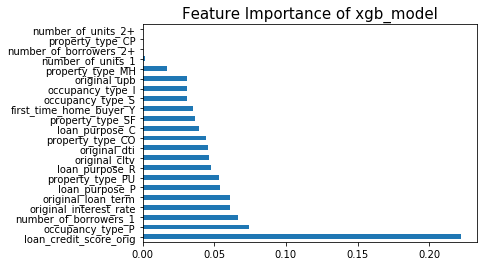

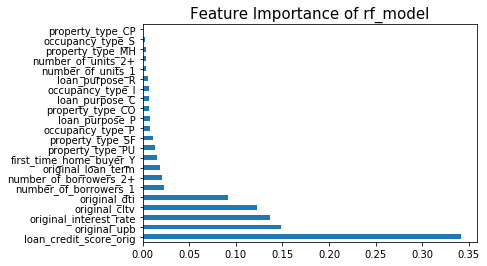

In [119]:
for name, model in model_list.items():
    if name == 'xgb_model' or name =='rf_model':
        feature(name, model, X_train)

From the feature importance, we can see credit score is the most important factor on default